# RAG evaluation 

Here we use the LLM as a judge method to evaluate the entire RAG workflow

# Our RAG workflow

In [23]:
import pandas as pd

#getting the dataset 

diy_dataset = pd.read_csv('../DIY_dataset/final_dataset.csv')
diy_dataset  = diy_dataset.dropna(subset='content')
diy_dataset_dict = diy_dataset.to_dict(orient='records')

#indexing and fitting our dataset

import minsearch

index = minsearch.Index(
    text_fields = ['chapter_title','content'],
    keyword_fields = ["playlist_title"]
)

index.fit(diy_dataset_dict)

#utility functions 

def search(query):
    #boost = {'question': 2.0,'section':0.5,'text':5.0}
    
    results = index.search(
        query= query,
        #filter_dict ={'course':'data-engineering-zoomcamp'},
        #boost_dict=boost,
        num_results=5
    )
    return results


def build_context(search_results):

    context = ""
    for doc in search_results:
        context = context  + f"playlist_title: {doc['playlist_title']}\nchapter_title:{doc['chapter_title']}\ncontent:{doc['content']}\n\n"


    return context        


def build_prompt(query,context):

    user_message = query + '\n The context is:\n ' + context
    return user_message


def create_system_message():
    system_message = """youre a DIY home improvement assistant. answer the question based only on the context. 
    
    """
    #use only facts from the context. if the context doesnt contain the answer, output NONE
    return system_message

def llm(user_message,system_message):
    import requests

    url = "http://localhost:1234/v1/chat/completions"
    headers = {
        "Content-Type": "application/json"
    }
    data = {
        "model": "Llama-3.2-3B-Instruct-GGUF",
        "messages": [
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_message}
        ],
        "temperature": 0,
        "max_tokens": -1,
        "stream": False
    }
    
    response = requests.post(url, headers=headers, json=data)
    return response.json()['choices'][0]['message']['content']

def answer_with_reference(search_results,answer):
    """this function adds the reference links returned from the retrieval step to the answer return from the LLM"""

    print(answer)
    print('\n')
    print('References:\n')

    for idx, result in enumerate(search_results):
        reference = str(idx+1)+ ' - ' + result['chapter_title'] +' - '+ result['clip_link']
        print(reference)
    
    return answer


def rag(query):
    
    search_results = search(query)
    #print(search_results)
    context = build_context(search_results)
    user_message = build_prompt(query,context)
    system_message = create_system_message()
    answer = llm(user_message,system_message)
    answer_and_reference = answer_with_reference(search_results,answer)
    return answer_and_reference






In [3]:
query = 'How to fix electricity outlet ?'
rag(query)

To fix an electricity outlet, first turn off the power at the circuit breaker or fuse box. Then mark around the outlet with a pencil and cut out the shape of the outlet box using a utility knife or jigsaw. Next, remove the old outlet and take note of the wiring connections. Remove any remaining screws or clips holding the wires in place.

Strip the insulation from the ends of the wires and identify which wire is black (hot), white (neutral), and copper (ground). Connect the wires to the new outlet box according to the manufacturer's instructions, making sure not to touch any of the wires together. Once connected, screw the wires into the outlet box using the correct screws.

Replace the outlet box with a new one, ensuring it is securely fastened to the wall. Finally, turn the power back on at the circuit breaker or fuse box and test the outlet to ensure it is working properly.


References:

1 - Electrical Outlet Box: <Untitled Chapter 1> - https://youtu.be/473e3hgbtV8?t=0
2 - How to I

In [12]:
#importing questions dataset used for evaluations
ground_truth = pd.read_csv('ground_truth_retrieval.csv')

#selecting 150 random questions to evaluate on
ground_truth = ground_truth.sample(n=150, random_state=42)

ground_truth = ground_truth.to_dict(orient='records')

In [40]:
len(ground_truth)

150

In [24]:
question = ground_truth[1]['questions']
answer_llm = rag(question)

Based on the provided context, blown-in insulation can be a cost-effective way to improve home insulation, especially in attics where traditional batt insulation may not fit snugly due to voids and cavities.

The recommended amount of insulation is up to 12 inches, which can help reduce heating and cooling bills. However, it's essential to measure the existing insulation thickness and determine how much more insulation is needed to reach the desired level.

Blown-in insulation can be a relatively cheap option, with prices ranging from $0.50 to $1.00 per square foot, depending on the type of insulation used. It's also an easy DIY project that can save homeowners money on energy costs in the long run.

However, it's crucial to note that blown-in insulation may not provide the same level of insulation as traditional batt insulation, especially if the attic is poorly ventilated or has significant gaps and voids. In such cases, additional measures may be necessary to ensure adequate insulat

In [27]:
# To run this code you need to install the following dependencies:
# pip install google-genai

from google import genai
from google.genai import types
from google.genai.errors import ClientError
def generate(prompt2_template):
    client = genai.Client(
        api_key="",  # Replace with your real API key here
    )
    model = "gemini-2.0-flash-lite"


    prompt = prompt2_template


    
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=prompt),
            ],
        ),
    ]
    tools = [
        types.Tool(googleSearch=types.GoogleSearch())
    ]
    generate_content_config = types.GenerateContentConfig(
        tools=tools,
    )

    # --- Collect chunks into a buffer ---
    buffer = []
    
    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        if chunk.text:
            buffer.append(chunk.text)
            
    # Join all chunks into one final string        
    return "".join(buffer)



In [38]:
def prompt2_tempate_create(question,answer_llm):
    prompt2_template = f"""
    You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
    Your task is to analyze the relevance of the generated answer to the given question.
    Based on the relevance of the generated answer, you will classify it
    as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".
    
    Here is the data for evaluation:
    
    Question: {question}
    Generated Answer: {answer_llm}
    
    Please analyze the content and context of the generated answer in relation to the question
    and provide your evaluation in parsable JSON without using code blocks:
    
    {{
      "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
      "Explanation": "[Provide a brief explanation for your evaluation]"
    }}
    """.strip()


    return prompt2_template
    

In [30]:

judgement = generate(prompt2_tempate_create())


In [32]:
judgement_cleaned =  judgement.strip('`').replace('json', '').strip()


In [35]:
import json 
judgement_cleaned = json.loads(judgement_cleaned)

In [37]:
judgement_cleaned['Relevance']

'RELEVANT'

In [41]:
ground_truth[0]

{'id': '1cf606a8-0bea-3d27-c0d4-3e475d2d1457',
 'questions': 'Can you install pot lights without damaging the ceiling?'}

In [43]:
import json
import pandas as pd
from tqdm import tqdm

results = []  # list to store all records

for record in tqdm(ground_truth):
    question = record['questions']
    answer_llm = rag(question)
    judgement = generate(prompt2_tempate_create(question, answer_llm))

    # Clean and parse the JSON safely
    judgement_cleaned = judgement.strip('`').replace('json', '').strip()
    try:
        judgement_json = json.loads(judgement_cleaned)
        judgement_relevance = judgement_json.get('Relevance', None)
    except json.JSONDecodeError:
        judgement_json = None
        judgement_relevance = None

    # Append to results list
    results.append({
        'question': question,
        'answer_llm': answer_llm,
        'judgement_json': judgement_json,
        'judgement_relevance': judgement_relevance
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Optionally save to disk
#df_results.to_csv("rag_evaluation_results.csv", index=False)

#print("✅ Results saved to rag_evaluation_results.csv")


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

Installing pot lights without damaging the ceiling is definitely possible, but it requires some care and attention to detail.

To avoid damaging the ceiling, make sure to:

1. Use a hole saw bit that fits perfectly into the drywall, as mentioned in the previous video.
2. Drill slowly and carefully, using reverse motion to prevent the drill from digging into the wire or causing damage.
3. Use a pilot bit to create a small hole, rather than trying to drill directly through the ceiling.
4. Avoid applying too much pressure or speed while drilling, as this can cause the drywall to crack or break.

By following these tips and taking your time, you should be able to install pot lights without damaging the ceiling. Additionally, using a low-voltage harness on the pot light box, as mentioned in the previous video, can also help prevent damage to the ceiling by allowing for more flexibility in terms of wire placement and connection.


References:

1 - How To Install Pot Lights in Kitchen Ceiling

  1%|▌                                                                               | 1/150 [00:35<1:28:48, 35.76s/it]

Based on the provided context, blown-in insulation can be a cost-effective way to improve home insulation, especially in attics where traditional batt insulation may not fit snugly due to voids and cavities.

The recommended amount of insulation is up to 12 inches, which can help reduce heating and cooling bills. However, it's essential to measure the existing insulation thickness and determine how much more insulation is needed to reach the desired level.

Blown-in insulation can be a relatively cheap and easy solution, especially for rental properties or homes with loose fill or bad insulation. It can also save homeowners money on heating costs by reducing heat loss in cold climates and heat gain in hot climates.

However, it's crucial to note that blown-in insulation may not provide the same level of R-value as traditional batt insulation, which is designed to fit snugly into the wall cavity. Nevertheless, blown-in insulation can still be an effective solution for improving home ins

  1%|█                                                                               | 2/150 [01:01<1:14:20, 30.14s/it]

Based on the context, fleux is not mentioned in the provided text. However, I found a mention of "fleux paste" in another part of the content.

In the context of soldering, fleux (also known as flux) is a substance applied to the metal surface before soldering to remove oxidation and promote the flow of solder. It's often used in conjunction with solder to help create a strong bond between the metals being joined.

So, in this case, it seems that the person is using fleux paste to prepare the copper cap for soldering.


References:

1 - Replace the Valve and Save the Plumbing!: add a little bit of fresh soldering - https://youtu.be/p8VDRvucpxQ?t=723
2 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
3 - How to Install Easy Ceiling Tile: repeat the process on the adjacent tile - https://youtu.be/leTg9kXAneg?t=265
4 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19
5 - DIY  How to Install a Show

  2%|█▌                                                                              | 3/150 [01:35<1:17:46, 31.74s/it]

The purpose of applying something to the cut ends of the studs, in this context, is likely to provide additional support and strength to the wall after removing the wall studs to create a bulkhead. The "something" referred to here is probably spackle or some other type of filler material, which is applied to the cut ends of the studs before installing the drywall or other finishes. This helps to:

1. Fill gaps: Spackle fills in any gaps or holes left by removing the wall studs.
2. Provide a smooth surface: By filling in the gaps, spackle creates a smoother surface for finishing materials like drywall or paneling.
3. Prevent further damage: Applying spackle to the cut ends of the studs helps prevent further damage to the surrounding area.

By doing so, the bulkhead is more stable and secure, making it easier to finish and install the desired material without worrying about gaps or uneven surfaces.


References:

1 - Build a Wall Niche and Add Charm & Style: attached to the cut ends of t

  3%|██▏                                                                             | 4/150 [02:13<1:22:41, 33.98s/it]

The purpose of the "DIY Finished Carpentry" series is not explicitly stated in the provided context, but it appears to be a collection of videos and tutorials focused on DIY home improvement projects, specifically carpentry-related tasks. The series seems to cover various topics such as installing wall-mounted hood fans, LED pot lights, coffered ceilings, framing bulkheads, and installing pre-hung doors.

Based on the content provided, it can be inferred that the purpose of this series is to educate viewers on how to complete common DIY carpentry tasks, providing step-by-step instructions and tips for a successful outcome. The series aims to empower homeowners and DIY enthusiasts with the knowledge and skills necessary to tackle various home improvement projects, making their homes more beautiful, functional, and efficient.

The tone of the content suggests that the creator is passionate about DIY home improvement and wants to share their expertise with others. The videos are likely de

  3%|██▋                                                                             | 5/150 [03:06<1:39:15, 41.07s/it]

The capacity of the drill bit provided with the product isn't explicitly mentioned, but based on the context, it seems like the 15/16" drill bit is being used to create holes for screws and other fasteners in various projects, including installing a new door and connecting plumbing lines.


References:

1 - Install French Doors YOURSELF! | DIY Tutorial: drill another hole in this wood with the same drill bit - https://youtu.be/dVr03Y6f8wM?t=2039
2 - How To Install A New Door In An Old Space: put the tip of the drill bit in the hole pound - https://youtu.be/noancs9-MX8?t=685
3 - How To Install A New Door In An Old Space: getting a mark from the metal drill bit on the handle - https://youtu.be/noancs9-MX8?t=1163
4 - Tim's Favorite Tools: Drill bit - https://youtu.be/6e-cPSYZJf4?t=47
5 - DIY Kitchen Plumbing 101 | Connecting Plumbing & Mounting the Sink: drill a hole near the top of the cabinet - https://youtu.be/WvtoWJdvP3I?t=67


  4%|███▏                                                                            | 6/150 [03:20<1:16:23, 31.83s/it]

Based on the provided context, it seems like you're looking for basic tools needed to rip out a bathroom. The text mentions using a crescent wrench, rubber gloves, a rag, and a large garbage bag.

So, some of the basic tools needed to rip out a bathroom are:

1. Crescent wrench
2. Rubber gloves
3. Rag
4. Large garbage bag

These tools should help you with tasks such as turning off the water supply, draining the tank, scooping out water from the bowl, and disposing of the waste.


References:

1 - How To Remove a Toilet: Tools Needed - https://youtu.be/Pem0LVFZU4w?t=20
2 - How To Install Basment Subfloor Tile System: Basic Tools - https://youtu.be/K31nXiOEWFg?t=127
3 - Tim's Favorite Tools: Intro - https://youtu.be/6e-cPSYZJf4?t=0
4 - How To Install Batt Insulation: Materials Needed - https://youtu.be/kJZsRM1nE78?t=240
5 - How to Remodel A Bathroom on a Budget | A to Z: Intro - https://youtu.be/WQI6ZTrfq4Q?t=0


  5%|███▋                                                                            | 7/150 [03:55<1:17:54, 32.69s/it]

The door was closed on top of the pencil because in the context of installing a new door, it's mentioned that "So you close it is at the top of my door" and then setting the top of the pin at the top of the door, implying that the door was closed to set the pin in place.


References:

1 - How To Install A New Door In An Old Space: set the top of the pin at the top of the door - https://youtu.be/noancs9-MX8?t=672
2 - Install French Doors YOURSELF! | DIY Tutorial: put on the catch in the top of the door jamb - https://youtu.be/dVr03Y6f8wM?t=1730
3 - Move Your Front Door Yourself! | Door Installation DIY: measure the top - https://youtu.be/JJWdYHU-VaM?t=1045
4 - How to Install A Pre Hung Door  |  3 Different Ways: attach all 18 of these screws on the interior of the door - https://youtu.be/ph2YCh85NQ0?t=1231
5 - Move Your Front Door Yourself! | Door Installation DIY: attach the two-by-four near the top - https://youtu.be/JJWdYHU-VaM?t=493


  5%|████▎                                                                           | 8/150 [04:06<1:01:25, 25.95s/it]

Based on the provided context, yes, gutters can be installed without a downspout. The text mentions that for sections of the roof that are nearly level, a gutter attached to this long portion of porch roof will naturally slope carrying rainwater toward one end and eventually into a downspout. However, it also states that "all gutters must slope at least one quarter inch for every 10 linear feet to provide proper drainage."


References:

1 - Ron Hazelton's HouseCalls - Season 17 - Lightweight Crown Molding - Install Gutters - Gas Fireplace: Lightweight Crown Molding - https://youtu.be/wEr-2seuYjQ?t=68
2 - How A Shower Surround Can Be an Attractive and Affordable Upgrade to Your Bathroom: Replace the Plumbing Fixtures - https://youtu.be/Kz7zKUIF8M4?t=581
3 - How A Shower Surround Can Be an Attractive and Affordable Upgrade to Your Bathroom: J Trim - https://youtu.be/Kz7zKUIF8M4?t=420
4 - How A Shower Surround Can Be an Attractive and Affordable Upgrade to Your Bathroom: <Untitled Chapte

  6%|████▉                                                                             | 9/150 [04:27<57:38, 24.53s/it]

Based on the context, DIY is considered a better option nowadays because it allows homeowners to take control of their home's maintenance and repairs, saving them money and time in the long run. Additionally, many modern plumbing components, such as shutoff valves, are designed to be easily replaced or modified, making DIY repairs more accessible and affordable.

In particular, the context highlights the importance of understanding the different types of shutoff valves and their applications, as well as the ability to replace or modify them without needing specialized skills. This suggests that DIY is becoming a more viable option for homeowners who want to tackle plumbing repairs on their own.

Furthermore, the emphasis on maintenance and prevention (e.g., checking gaskets and washer connections) implies that DIY is not just about fixing problems, but also about taking proactive steps to prevent issues from arising in the first place. This approach can help homeowners save money and r

  7%|█████▎                                                                         | 10/150 [04:59<1:02:03, 26.60s/it]

Based on the context, the purpose of using plywood in this project is to create a solid surface underneath the door or bulkhead, allowing for easy installation and adjustment. The 5/8 inch plywood provides a stable base for the door or bulkhead, ensuring that it is level and secure. This is particularly important when installing a bulkhead around ductwork or plumbing, as mentioned in the second playlist title and chapter title.


References:

1 - How To Hang An Interior Door Quick and Easy: add 5 / 8 plywood - https://youtu.be/h1nMWfLiQC4?t=74
2 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
3 - This Is Why Your Toilet Drips: <Untitled Chapter 1> - https://youtu.be/hg5GlGOo-j0?t=0
4 - This Is Why Your Toilet Drips: change the interior part of the valve - https://youtu.be/hg5GlGOo-j0?t=442
5 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19


  7%|█████▊                                                                         | 11/150 [05:34<1:07:34, 29.17s/it]

Based on the context, Tim Carter isn't worried about the cold weather because he's working in his church, which is being renovated, and the studio is a 10-foot ceiling, indicating it's likely an indoor space with controlled temperature.


References:

1 - This Is Why Your Toilet Drips: <Untitled Chapter 1> - https://youtu.be/hg5GlGOo-j0?t=0
2 - This Is Why Your Toilet Drips: change the interior part of the valve - https://youtu.be/hg5GlGOo-j0?t=442
3 - How To Install LED Pot Lights In a Finished Ceiling | DIY: Why 6 Inch Light Is Best - https://youtu.be/pc5HWB-tyng?t=78
4 - This Is Why Your Toilet Drips: shut off the the main supply to the house - https://youtu.be/hg5GlGOo-j0?t=378
5 - Replace the Valve and Save the Plumbing!: take apart the old valve the hot and the cold lines - https://youtu.be/p8VDRvucpxQ?t=260


  8%|██████▍                                                                          | 12/150 [05:51<58:40, 25.51s/it]

To apply silicone to the back of the trim, follow these steps:

1. Remove the tip from the gun.
2. Use a wand attached to the gun to puncture the seal and release the silicone.
3. Cut the silicone on an angle to make it easier for installation.
4. Clean your hands and area with towels to prevent contamination.
5. Apply a bead of clear silicone to the back of the trim, starting at the top and working down.
6. Use a dry finger to smooth out the bead and fill any gaps or joints.
7. Press the trim into place, using a thumb to push it firmly against the wall or ceiling.
8. Use a rag to wipe away any excess silicone from the trim's edges.

For the tub-to-tile joint:

1. Apply a bead of clear silicone to the back of the trim, starting at the top and working down.
2. Press the trim into place, using a thumb to push it firmly against the wall or ceiling.
3. Use a dry finger to smooth out the bead and fill any gaps or joints.

For the final joint:

1. Apply a bead of clear silicone to the edge o

  9%|██████▊                                                                        | 13/150 [06:40<1:14:55, 32.81s/it]

The creator mentioned a specific link in the video description because they wanted to provide additional resources or information for viewers who want to learn more about the topic being discussed, but didn't include it in the main content of the video. This is often done with DIY home improvement projects where the creator wants to encourage viewers to take action and try out the project themselves, but also wants to provide a way for them to access additional information or tutorials if needed.


References:

1 - This Is Why Your Toilet Drips: change the interior part of the valve - https://youtu.be/hg5GlGOo-j0?t=442
2 - How To Install LED Pot Lights In a Finished Ceiling | DIY: Why 6 Inch Light Is Best - https://youtu.be/pc5HWB-tyng?t=78
3 - This Is Why Your Toilet Drips: shut off the the main supply to the house - https://youtu.be/hg5GlGOo-j0?t=378
4 - Ron Hazelton's HouseCalls Season 17 - Install USB Outlet - DIY Home Office - Attract Songbirds: Project Description - https://youtu

  9%|███████▎                                                                       | 14/150 [07:02<1:06:43, 29.44s/it]

Based on the context, I believe that a crimper works by using a tool with a series of small holes or teeth to compress and shape metal pipes into a new diameter.

In the context of plumbing, it seems that the crimper is used to expose all the pipes in a basement bathroom, allowing a plumber to work on them. The crimper is likely used to cut through the pipe insulation or other materials to access the pipes underneath.

The process involves cutting out a hole in the wall and then using a crimper to remove the insulation or other materials around the pipe, exposing it for the plumber to work on.


References:

1 - DeWalt Wet Saw: How does a ceramic saw work - https://youtu.be/P3OqX_ORi7I?t=42
2 - Complete How To Guide for Basement Bathroom Plumbing: expose all the pipes - https://youtu.be/RJPYruflhXw?t=42
3 - Great Gloves for Work: Work Gloves - https://youtu.be/te02hcpwpKE?t=13
4 - Install Crown Molding Without Nails: leaving an opening of about an eighth of an inch in diameter - https:

 10%|████████                                                                         | 15/150 [07:17<56:34, 25.14s/it]

According to the context, viewers can find additional videos and resources for wall framing on the YouTube channel and website at houseimprovements.com, as well as on the forum.


References:

1 - How To Install A Floating Wall System: framing the building of the wall - https://youtu.be/H-TXec0CQ8E?t=420
2 - How to Install a Bath Tub: Framing - https://youtu.be/ziYQaxYQv94?t=195
3 - A Good Way To Insulate Your Basement Walls: Framing - https://youtu.be/cCFFuL4J0jQ?t=85
4 - How To Install LED Pot Lights In a Finished Ceiling | DIY: Find Floor Joists - https://youtu.be/pc5HWB-tyng?t=465
5 - How to Make a Double Sink in Your Home | Bathroom Remodel DIY: Find Center Line - https://youtu.be/OQjxCb7wP6U?t=574


 11%|████████▋                                                                        | 16/150 [07:28<46:17, 20.73s/it]

To change a light switch, you typically need to:

1. Turn off the circuit breaker or switch that controls the power to the light fixture.
2. Remove the faceplate or cover plate from the wall to access the wires behind it.
3. Identify the correct wire connections for the new switch (usually black and white wires).
4. Loosen the screws holding the old switch in place, then carefully pull it out of the electrical box.
5. Connect the wires to the new switch, making sure they are securely attached with the correct screw or clip.
6. Replace the faceplate or cover plate over the new switch.

Note that if you're replacing a 3-way or 4-way switch, additional steps may be required, such as identifying and connecting the third wire (for 3-way switches) or using a specialized adapter for 4-way switches.


References:

1 - Light Switch Wiring: Light Switch Wiring - https://youtu.be/LLPDl3o59iQ?t=5
2 - 3 Way Switch: The 3 way switch - https://youtu.be/LDyvcM0gcVs?t=42
3 - How to Wire a 4 Way Switch:

 11%|█████████▏                                                                       | 17/150 [07:50<46:47, 21.11s/it]

Joist ends work with basement finishing kits by using shims, which are plastic pieces that can be stacked and placed under the joists to create a level surface. This is especially useful when there's a low spot in the floor or when installing tile systems.

In the context of the provided content, it seems that the author uses shims to support the floor joists at the edges of the basement, where they're not directly attached to the wall. The shims are placed under the joist ends to create a level surface and provide additional support.

The use of shims is particularly relevant when installing tile systems, as it allows for a more precise fit and prevents unevenness in the floor. In this case, the author mentions that they'll be using shim kits, which are specifically designed for this purpose.

Overall, joist ends work with basement finishing kits by utilizing shims to create a level surface and provide additional support, especially when installing tile systems or dealing with low spo

 12%|█████████▋                                                                       | 18/150 [08:11<46:41, 21.23s/it]

Based on the context, it appears that the type of sealant used in this sink design is a polyurethane sealant. This is mentioned in the "How to Build a Shed: Part 5 | Doors & Windows: Exterior Sealant" chapter, where the author discusses using polyurethane exterior sealant for bonding with different wood products and plastic products.


References:

1 - DIY Bathroom Sink Removal: Clips Holding the Undermount Sink - https://youtu.be/jSbkdb9DWs8?t=46
2 - How to Build a Shed: Part 5 | Doors & Windows: Exterior Sealant - https://youtu.be/o1PayLsEg3A?t=566
3 - Install a Kitchen Sink the RIGHT Way! | Sink, Faucet & Drain Tutorial: remove the sink - https://youtu.be/HLi0ZVJKzYM?t=199
4 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
5 - How To Install a Kitchen Sink and Drain For Beginners | Church Flip | Episode 7: Sink Installation - https://youtu.be/vln5rN9rqR8?t=583


 13%|██████████▎                                                                      | 19/150 [08:50<57:57, 26.54s/it]

To rock an object back and forth, you would typically use a gentle, oscillating motion to help secure or adjust something in place. This could be useful when installing or adjusting various components, such as ceiling tiles, molding, or even plumbing fixtures.

In the context of the provided content, it seems that rocking an object back and forth might be relevant when applying adhesive to the back side of molding for ceiling tile installation. The instruction is to "press the molding into the corner using a flat hand" which implies a gentle pressing motion, possibly accompanied by a slight rocking or tilting action to ensure proper alignment and secure adhesion.


References:

1 - This Is Why Your Toilet Drips: <Untitled Chapter 1> - https://youtu.be/hg5GlGOo-j0?t=0
2 - This Is Why Your Toilet Drips: change the interior part of the valve - https://youtu.be/hg5GlGOo-j0?t=442
3 - How To Install LED Pot Lights In a Finished Ceiling | DIY: Why 6 Inch Light Is Best - https://youtu.be/pc5HW

 13%|██████████▊                                                                      | 20/150 [09:13<55:14, 25.50s/it]

When installed on the wall, the molding should be cut at a 45-degree angle.


References:

1 - Goodbye Popcorn Hello Elegant New Look: cut the miters on the ends of the molding - https://youtu.be/4JcRpQSi1cY?t=381
2 - How to Install Easy Ceiling Tile: the cut at 45 degrees - https://youtu.be/leTg9kXAneg?t=333
3 - Stack Trim to Make your Crown Molding Bigger: Compound Miter Cut - https://youtu.be/JvxhSALulCk?t=280
4 - Install Crown Molding Without Nails: cut a 45 degree miter on the end of the second piece - https://youtu.be/8_zudnZqsG8?t=181
5 - Install Crown Molding Without Nails: cut a 45 degree miter on the end of one moulding - https://youtu.be/8_zudnZqsG8?t=51


 14%|███████████▎                                                                     | 21/150 [09:19<42:10, 19.62s/it]

Based on the context, thicker materials like brass tend to heat up more slowly than thinner materials. In the provided content, it's mentioned that "The brass is very thick... And it takes a long time to heat up." This suggests that heating up brass can be a slower process compared to other materials.


References:

1 - Replace the Valve and Save the Plumbing!: add heat to the brass - https://youtu.be/p8VDRvucpxQ?t=633
2 - DIY How To Install A Heat Duct Going To The Floor in Your Basement: take the heat level from around the ceiling - https://youtu.be/dsI_3lbwO7E?t=66
3 - Replace the Valve and Save the Plumbing!: take apart the old valve the hot and the cold lines - https://youtu.be/p8VDRvucpxQ?t=260
4 - How to Install a Bath Tub: Brass Drain Kit - https://youtu.be/ziYQaxYQv94?t=304
5 - DIY How To Install A Heat Duct Going To The Floor in Your Basement: <Untitled Chapter 1> - https://youtu.be/dsI_3lbwO7E?t=0


 15%|███████████▉                                                                     | 22/150 [09:30<36:19, 17.02s/it]

The sharpness of the blade affects the job by determining how easily and effectively it can cut through materials. A dull blade will require more force, cause more tear-out, and produce a rough finish, whereas a sharp blade will make clean cuts with less effort, resulting in a smoother finish.

In the context of the provided content, the author mentions that they have been using a 60-tooth fine tooth blade for a long time, but it has worn out its usefulness. They suggest replacing it with a new one to achieve better results and a finished look. The sharpness of the blade is also important when working with materials like ceramic tile (as in the DeWalt Wet Saw content) or cutting crown molding (as in the Install Crown Molding Without Nails content).


References:

1 - How to Build a Shed: Part 5 | Doors & Windows: Change the Blade - https://youtu.be/o1PayLsEg3A?t=1553
2 - DeWalt Wet Saw: How does a ceramic saw work - https://youtu.be/P3OqX_ORi7I?t=42
3 - Install Crown Molding Without Na

 15%|████████████▍                                                                    | 23/150 [09:45<34:35, 16.34s/it]

It appears that removing some of the material from the hinges is necessary to create space for the hinge pin, which allows for proper alignment and function. This process involves drilling out the existing hole in the hinge and creating a shim by chipping away at the wood to fit the new pin. By doing so, you can ensure a smooth and secure installation of the hinges.


References:

1 - How To Paint Doors and Trim | DIY: Remove the Hinges - https://youtu.be/diBvKzJHjM0?t=102
2 - This Is Why Your Toilet Drips: <Untitled Chapter 1> - https://youtu.be/hg5GlGOo-j0?t=0
3 - This Is Why Your Toilet Drips: change the interior part of the valve - https://youtu.be/hg5GlGOo-j0?t=442
4 - Install French Doors YOURSELF! | DIY Tutorial: attach all the other hinges - https://youtu.be/dVr03Y6f8wM?t=1495
5 - How To Install A New Door In An Old Space: pick up the same three-inch hinges - https://youtu.be/noancs9-MX8?t=355


 16%|████████████▉                                                                    | 24/150 [10:05<36:55, 17.58s/it]

In the context of the provided text, "24/7" likely refers to a 24-hour, 7-day-a-week availability or service, implying that something is always available or accessible at any time.


References:

1 - Benefit of a Ceiling Fan Heater: What does running a ceiling fan in reverse do? - https://youtu.be/2D1oxRcSOeA?t=1
2 - Ron Hazelton's HouseCalls - Season 17 - Convert a Door into a Bookcase - Build a Backyard PlaySet: Outro - https://youtu.be/5UTShy8WPkM?t=1090
3 - DIY How to Renovate the Tub / Shower from A to Z: 2:40:24​ Quick Wall Repairs - https://youtu.be/NS6TPiHaN2Y?t=9211
4 - How To Install A New Door In An Old Space: installing a brand new door in an existing hole - https://youtu.be/noancs9-MX8?t=7
5 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0


 17%|█████████████▌                                                                   | 25/150 [10:35<44:27, 21.34s/it]

Based on the context, I would say that cutting jobs are typically built from wood. This can be inferred from the mention of "wood" in the chapter title "Cordless Reciprocating Saw: Built for Durability" and the content discussing using a sawed material (presumably wood) to install crown molding without nails.


References:

1 - Cordless Reciprocating Saw: Built for Durability - https://youtu.be/TS8TzxCo3Gw?t=37
2 - Install Crown Molding Without Nails: cutting with the material in the vertical position - https://youtu.be/8_zudnZqsG8?t=79
3 - Cordless Reciprocating Saw: Wonderful Pistol Grip - https://youtu.be/TS8TzxCo3Gw?t=40
4 - Nail Guns: Nail Guns - https://youtu.be/yzQ9vyF7D64?t=36
5 - Cordless Reciprocating Saw: <Untitled Chapter 1> - https://youtu.be/TS8TzxCo3Gw?t=0


 17%|██████████████                                                                   | 26/150 [10:44<35:52, 17.36s/it]

It appears that the DIY home improvement project involves installing a shower valve with copper and PEX plumbing in a bathroom. The goal is to install the shower valve, which includes hot and cold shutoffs, integrated PEX adapters, and a tub line with a three-quarter inch PEX adapter. 

The context suggests that the installation will involve crimping the copper lines together using a compression fit inside a wall cavity, followed by installing the shower arm in the wall using Teflon tape and thread sealer paste. The project also involves measuring and marking the location of the shower head on the wall, as well as installing a finishing trim kit to cover the hole perfectly.

The overall objective is to create a functional and efficient plumbing system for the shower, while ensuring that it meets the necessary standards for water pressure and flow rate.


References:

1 - DIY How To Install Copper To Pex Shower and Bath Plumbing: Installing the Shower Valve - https://youtu.be/jgkCmT8Cc9

 18%|██████████████▌                                                                  | 27/150 [11:07<39:15, 19.15s/it]

The starting point for the ceiling installation is determined by measuring out the width of the border tile at each end, marking the distance, and then using that measurement to cut tiles to fit around the perimeter of the room. The center point of the ceiling is also used as a reference point, with the tiles being installed from the center outward.


References:

1 - How to Install a Faux Metal Ceiling: Measure Out the Width of the Border Tile - https://youtu.be/BzhHCmu2eDM?t=220
2 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: The Border Tiles - https://youtu.be/uDnJuJHX2TM?t=537
3 - How to Install Embossed Ceiling Tiles: Installing the Tiles - https://youtu.be/zYgNZ9Oz7rY?t=139
4 - How to Install Easy Ceiling Tile: attach the tiles for the ceiling - https://youtu.be/leTg9kXAneg?t=109
5 - How to Install Easy Ceiling Tile: begin putting up the tiles at the center of the ceiling - https://youtu.be/leTg9kXAneg?t=72


 19%|███████████████                                                                  | 28/150 [11:16<33:05, 16.27s/it]

The latex paint scratches easily on bathroom doors because it's not designed for high-moisture areas like bathrooms. Latex paint is a water-based paint that can be damaged by moisture, which causes it to peel and flake off. Bathroom doors are exposed to high humidity and moisture from the air, shower, and bathtub, making them prone to damage from latex paint.

There are several reasons why latex paint doesn't work well on bathroom doors:

1. **Moisture**: Latex paint is sensitive to moisture, which causes it to swell and peel off.
2. **Humidity**: Bathroom doors are exposed to high humidity, which can cause the paint to degrade quickly.
3. **Water damage**: Water from showers, bathtubs, or leaks can seep into the door and cause the paint to peel and flake off.

To solve this problem, you can use a paint specifically designed for bathrooms, such as:

1. **Epoxy paint**: A two-part epoxy paint that's resistant to moisture and humidity.
2. **Acrylic enamel paint**: A high-gloss paint that

 19%|███████████████▎                                                               | 29/150 [13:01<1:26:14, 42.77s/it]

Based on the context, it appears that the sections of molding required per wall are not explicitly stated. However, it can be inferred that the author is discussing how to install crown molding without nails and how to apply adhesive to the back of the molding.

In general, when installing crown molding, a standard rule of thumb is to use 1/4" or 6mm wide strips for interior walls and 3/8" or 9mm wide strips for exterior walls. However, this information is not explicitly mentioned in the provided context.

It's also worth noting that the author mentions using "about two foot sections" when applying material, but this seems to be related to ceiling tile installation rather than crown molding.


References:

1 - Build a Wall Niche and Add Charm & Style: removing these sections of wall studs - https://youtu.be/u43F8_6TXUE?t=278
2 - Install Crown Molding Without Nails: conform to the molding profile rolling the sandpaper into a small cylinder - https://youtu.be/8_zudnZqsG8?t=250
3 - How to

 20%|███████████████▊                                                               | 30/150 [13:15<1:08:22, 34.19s/it]

Based on the context of the safety jacket being wind resistant and water resistant, I would guess that the other colors besides fire engine red, black, and camouflage are likely to be neutral or earthy tones such as olive green, navy blue, or gray. However, without more information, it's difficult to say for certain.


References:

1 - Milwaukee Heated Jacket: Nice Hood - https://youtu.be/xAo_qj8mm4E?t=43
2 - Milwaukee Heated Jacket: <Untitled Chapter 1> - https://youtu.be/xAo_qj8mm4E?t=0
3 - Milwaukee Heated Jacket: Wind Resistant - https://youtu.be/xAo_qj8mm4E?t=40
4 - Benefit of a Ceiling Fan Heater: What does running a ceiling fan in reverse do? - https://youtu.be/2D1oxRcSOeA?t=1
5 - Milwaukee 6146-30 Grinder Review: Safety - https://youtu.be/q5lkEOZh8L0?t=39


 21%|████████████████▋                                                                | 31/150 [13:25<53:16, 26.86s/it]

Patreon is a membership platform that allows content creators to earn money from their fans and supporters in exchange for exclusive content, early access, or other perks.

In the context of the DIY home improvement videos, the creator mentions that they have a Patreon campaign where viewers can pledge support to help them produce more content. The link to their Patreon campaign is provided in the video description, allowing viewers to learn more about the benefits of supporting the channel and how it will help the creators continue to produce high-quality content.

By supporting the channel on Patreon, viewers can expect to receive exclusive content, such as behind-the-scenes footage, early access to new videos, or even personalized advice from the creator. The Patreon campaign is a way for the creator to monetize their expertise and build a community of loyal fans who appreciate their work.


References:

1 - How To Install Vapor Barrier: Patreon - https://youtu.be/7cz4y1U7bi0?t=1180

 21%|█████████████████▎                                                               | 32/150 [14:01<58:04, 29.53s/it]

The use of a two-person team can significantly affect the precision of tile placement, especially when working with curved cuts like those required for toilet flanges and ceiling tiles.

With one person handling the cutting and another assisting with the placement, you can ensure that the cut is accurate and precise. The second person can also help to hold the tile in place while the first person makes the cut, reducing the risk of errors or uneven cuts.

In the context of installing ceiling tiles, a two-person team can be particularly beneficial when measuring and marking the tiles for placement. One person can measure and mark the tiles, while the other person holds the tile in place and ensures that it is aligned properly with the chalk line.

Overall, having a second pair of hands can greatly improve the precision and accuracy of tile placement, especially when working with complex cuts or curved shapes.


References:

1 - How To Cut A Floor Tile Circle For Toilet Flange: use a cou

 22%|█████████████████▊                                                               | 33/150 [14:15<48:54, 25.08s/it]

To determine if a wall is load-bearing, follow these steps:

1. **Check the location of studs**: Load-bearing walls typically have studs spaced 16 inches on center (o.c.). If you find studs spaced this far apart, it's likely a load-bearing wall.
2. **Look for headers and footers**: Headers are horizontal beams that span across the top of openings, such as doorways or windows. Footers are vertical beams at the bottom of walls. These components indicate a load-bearing wall.
3. **Check for plumbing, electrical, or HVAC components**: Load-bearing walls often have these components running through them. If you find pipes, wires, or ducts in the studs, it's likely a load-bearing wall.
4. **Inspect the wall's thickness**: Load-bearing walls are typically thicker than non-load-bearing walls.
5. **Check for any signs of reinforcement**: Look for metal studs or other reinforcements that indicate a load-bearing wall.

If you're still unsure, consult with a professional contractor or structural eng

 23%|█████████████████▉                                                             | 34/150 [15:21<1:12:16, 37.38s/it]

Based on the context, common tools used for cleaning and construction projects are:

* Power tools (e.g., vacuum cleaners with self-cleaning mechanisms)
* Screwdrivers
* Drill bits
* Adhesives (construction adhesive)
* Hammers
* Pencils and markers for measuring and marking surfaces
* Tape measures
* Leveling tools

These tools are mentioned in various chapters of the playlist, including "Tim's Favorite Tools: Intro", "Internet Cable: Which pairs are used in an Ethernet cable?", "Wet Dry Vacuum Cleaners: Self-Cleaning Mechanism", "How To Install a Keypad Electronic Lock Set: Construction", and "How to Install a Ceiling Medallion: attach this lightweight medallion to the ceiling with construction adhesive".


References:

1 - Tim's Favorite Tools: Intro - https://youtu.be/6e-cPSYZJf4?t=0
2 - Internet Cable: Which pairs are used in an Ethernet cable? - https://youtu.be/hEHGiO6gKyQ?t=24
3 - Wet Dry Vacuum Cleaners: Self-Cleaning Mechanism - https://youtu.be/XaTO2cqCqjY?t=63
4 - How To Ins

 23%|██████████████████▉                                                              | 35/150 [15:38<59:31, 31.06s/it]

Based on the context, I believe the weight for the pull-down hose used for is likely related to a wet/dry vacuum cleaner. In the "Power Tools" chapter titled "Wet Dry Vacuum Cleaners: Locking Hose", it mentions that the hose has a locking mechanism and can be pulled around without detaching from the vacuum cleaner, indicating that it's designed for heavy-duty use in a workshop or construction setting.


References:

1 - How To Install A Recessed Pot Light: pull the ceiling tile back down into position - https://youtu.be/dBQJdFxn-Ys?t=75
2 - Wet Dry Vacuum Cleaners: Locking Hose - https://youtu.be/XaTO2cqCqjY?t=81
3 - Complete How To Guide for Basement Bathroom Plumbing: the size of the pipe for the wet vent - https://youtu.be/RJPYruflhXw?t=120
4 - Replace the Valve and Save the Plumbing!: pull the bottom off - https://youtu.be/p8VDRvucpxQ?t=339
5 - Install a Kitchen Sink the RIGHT Way! | Sink, Faucet & Drain Tutorial: cut down through the gable side of this cabinet - https://youtu.be/H

 24%|███████████████████▍                                                             | 36/150 [15:49<47:51, 25.19s/it]

To establish a level line around the room for a suspended ceiling, you can use a laser level. This is the fastest and most accurate way to do so, and it can be rented or purchased for under $50. Alternatively, you can measure down at two points on a wall, drive in a nail, and strike a chalk line.


References:

1 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: To Establish a Level Line around the Room - https://youtu.be/uDnJuJHX2TM?t=110
2 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: A Suspended or Dropped Ceiling Really Consists of Three Components - https://youtu.be/uDnJuJHX2TM?t=247
3 - Laser Level: Intro - https://youtu.be/qM0jheNhrjc?t=0
4 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: Several Advantages to a Drop Ceiling - https://youtu.be/uDnJuJHX2TM?t=12
5 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: The Main Beams - https://youtu.be/uDnJuJHX2TM?t=251


 25%|███████████████████▉                                                             | 37/150 [15:59<38:28, 20.43s/it]

In this context, "all your joints" likely refers to the joints of the p-trap (a curved pipe under a sink) when connecting it with other plumbing components. It implies that all the connections and fittings need to be secure and properly attached at their joints for a watertight seal.


References:

1 - How to Install a Glass Door in 30 Minutes | Home DIY Timed Challenge: apply some structural silicone and all your joints - https://youtu.be/GlabzA8GbfA?t=3121
2 - Benefit of a Ceiling Fan Heater: What does running a ceiling fan in reverse do? - https://youtu.be/2D1oxRcSOeA?t=1
3 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
4 - DIY Kitchen Plumbing 101 | Connecting Plumbing & Mounting the Sink: connect our p-trap with their joints - https://youtu.be/WvtoWJdvP3I?t=1253
5 - Watch this before you put a bathroom in your basement | Bathroom Rough In Tips: Framing - https://youtu.be/JK6esDuKPMQ?t=230


 25%|████████████████████▌                                                            | 38/150 [16:25<41:38, 22.31s/it]

To create strips of varying widths from standard 1x4s and 1x6s, you can use a table saw to make bevel cuts along the edges of the boards at a 45-degree angle. This will allow you to cut the boards into strips with different widths.

Next, measure and mark the desired length for each strip on the power miter saw, and then make your cuts.


References:

1 - How to Build a Post & Beam Archway: fashion the individual pieces for the beam post and braces - https://youtu.be/lPJgzT4oZeQ?t=81
2 - How To Install A Copper Stamped Metal Ceiling: attached to one by three furring strips - https://youtu.be/jGeMQUsoqCI?t=109
3 - How to Build a Post & Beam Archway: make angle cuts or bevels along the edges - https://youtu.be/lPJgzT4oZeQ?t=93
4 - How To Install A Copper Stamped Metal Ceiling: begin by installing furring strips around the perimeter of the room - https://youtu.be/jGeMQUsoqCI?t=184
5 - Install French Doors YOURSELF! | DIY Tutorial: shim behind every one of these hinge positions - https://y

 26%|█████████████████████                                                            | 39/150 [16:36<34:56, 18.89s/it]

Based on the provided context, it appears that the content is being heated up in the form of duct work in a basement ceiling. The speaker, Shannon from Host Improvements, is framing a bulkhead to cover the duct work and mentions using metal stud track, utility angle metal channel, 2x4s, and 1x4s to create the framework for the drywall to be attached to.


References:

1 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
2 - Milwaukee Heated Jacket: <Untitled Chapter 1> - https://youtu.be/xAo_qj8mm4E?t=0
3 - How To Install A New Door In An Old Space: line this up in the direction that the door is closing - https://youtu.be/noancs9-MX8?t=1122
4 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19
5 - Information on BluWood Treated Wood: What is blue treated lumber? - https://youtu.be/kzUMhxzXI60?t=11


 27%|█████████████████████▌                                                           | 40/150 [17:07<41:12, 22.48s/it]

The paneling was chosen for their den ceiling because it would have a dramatic effect, as mentioned in the context: "they knew paneling would have a dramatic effect".


References:

1 - How to Install Wooden Ceiling Panels: <Untitled Chapter 1> - https://youtu.be/Fv9KQMu8aXg?t=0
2 - How to Build a Shed: Part 5 | Doors & Windows: Exterior Paneling - https://youtu.be/o1PayLsEg3A?t=1881
3 - How To Install LED Pot Lights In a Finished Ceiling | DIY: Why 6 Inch Light Is Best - https://youtu.be/pc5HWB-tyng?t=78
4 - Ron Hazelton's HouseCalls Season 18- Tile over Concrete - DIY Wood Ceiling - Remove Screw w/ No Head: DIY Wood Ceiling - https://youtu.be/gCRmW_NDM7A?t=497
5 - How to Install Easy Ceiling Tile: attach the tiles for the ceiling - https://youtu.be/leTg9kXAneg?t=109


 27%|██████████████████████▏                                                          | 41/150 [17:23<37:03, 20.40s/it]

The purpose of microphase hardening in oscillating tool blades is to improve performance and keep the tool sharper for longer.


References:

1 - Ron Hazelton's HouseCalls Season 18 - Oscillating Blades - Replacement Windows - Repair Wall Texture: Zenith Oscillating Blades - https://youtu.be/8vpLg_NKY0U?t=84
2 - Ron Hazelton's HouseCalls Season 18 - Oscillating Blades - Replacement Windows - Repair Wall Texture: Intro - https://youtu.be/8vpLg_NKY0U?t=0
3 - Circular Saw Blades: Types of Circular Saw Blades - https://youtu.be/dbYMaie2OhY?t=13
4 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
5 - Circular Saw Blades: Intro - https://youtu.be/dbYMaie2OhY?t=0


 28%|██████████████████████▋                                                          | 42/150 [17:47<39:05, 21.72s/it]

Based on the context, it seems that the laminate flooring is slightly thicker than the existing carpet edge because the installer is using a transition strip (carpet bevel bar) to create an angled transition from the carpet surface up to the top of the vinyl plank flooring. This is done to ensure a smooth and even installation, especially around obstacles like partial walls and door frames.


References:

1 - How To Install Basment Subfloor Tile System: Vinyl Plank Flooring - https://youtu.be/K31nXiOEWFg?t=1367
2 - How To Install Basment Subfloor Tile System: Carpet Bevel Bar - https://youtu.be/K31nXiOEWFg?t=1387
3 - This Is Why Your Toilet Drips: change the interior part of the valve - https://youtu.be/hg5GlGOo-j0?t=442
4 - This Is Why Your Toilet Drips: <Untitled Chapter 1> - https://youtu.be/hg5GlGOo-j0?t=0
5 - This Is Why Your Toilet Drips: shut off the the main supply to the house - https://youtu.be/hg5GlGOo-j0?t=378


 29%|███████████████████████▏                                                         | 43/150 [18:03<35:16, 19.78s/it]

Based on the context, here are the answers:

1. What is Tim Carter's website?
Answer: askthebuilder.com
2. How does one subscribe to Tim Carter's newsletter?
Answer: Click the link below in the description of the video or visit askthebuilder.com and sign up for the free newsletter.
3. What kind of content can be found on Tim Carter's website?
Answer: Tool reviews, product reviews, helpful tips, new tool reviews, new product reviews, great tips, home improvement tips.
4. Why would someone want to subscribe to Tim Carter's newsletter?
Answer: To get tips like that for free each week in their email box, including new tool reviews, new product reviews, and great tips.
5. What benefits come with subscribing to Tim Carter's newsletter?
Answer: Free access to helpful tips, new tool reviews, new product reviews, and home improvement tips every week.


References:

1 - Great Gloves for Work: FREE Ask the Builder Newsletter - https://youtu.be/te02hcpwpKE?t=229
2 - DeWALT Saw Stand Tips: Subscrib

 29%|███████████████████████▊                                                         | 44/150 [18:17<32:14, 18.25s/it]

Based on the context, it seems that the pump shut off after being activated because of a low water level in the sump pit. The narrator mentions that when they tested the pump, there was barely enough water in the pit to run it, but as soon as more water was added, the pump turned off on its own due to the float activating and shutting off the power.


References:

1 - This Is Why Your Toilet Drips: shut off the the main supply to the house - https://youtu.be/hg5GlGOo-j0?t=378
2 - How To Install A Sump Pump: activate the 12 volt pump - https://youtu.be/ABsk_4zrlbM?t=680
3 - How To Install A Sump Pump: <Untitled Chapter 1> - https://youtu.be/ABsk_4zrlbM?t=0
4 - How To Install A Toilet So It Won't Leak | DIY For Beginners: Shut Off Water Supply - https://youtu.be/eIkPTezSkx4?t=45
5 - How To Install A Sump Pump: turn the alarm off - https://youtu.be/ABsk_4zrlbM?t=610


 30%|████████████████████████▎                                                        | 45/150 [18:35<31:25, 17.96s/it]

Based on the context, it seems that you're looking for a way to ensure a smooth finish after installing brick bolts.

In this case, I would recommend using a joint compound or spackling paste to fill in any gaps or holes around the brick bolts. This will help create a smooth surface for painting or finishing.

Additionally, you may want to consider applying a layer of primer or texture additive to the joint compound to ensure a uniform finish and prevent any unevenness.

It's also worth noting that if you're using toggle bolts, which are designed to provide extra holding power in heavy applications, you may need to use a specialized anchor or insert to secure them properly. Be sure to follow the manufacturer's instructions for installation and recommendations for ensuring a smooth finish.

Overall, the key is to create a solid foundation for your brick bolts and ensure that they're securely fastened to the wall. With a little patience and attention to detail, you can achieve a professi

 31%|████████████████████████▊                                                        | 46/150 [19:26<48:28, 27.97s/it]

Based on the provided context, it appears that the hardware showcased in the videos is related to door installation and bulkhead framing.

In the "Doors" playlist, the hardware mentioned includes:

* A pre-mortise store (a type of lock)
* A deadbolt
* Latches for a traditional plate
* Strike plates

These are all used in the installation of doors and locks.

In the "Basements" playlist, the hardware mentioned is related to bulkhead framing. The specific hardware shown includes:

* Metal stud track
* Utility angle metal channel
* 2x4s
* Wafer screws

This hardware is used to create a framework for suspending drywall in a basement or other area where ductwork or plumbing needs to be covered.

It's worth noting that the context of these videos suggests that the hardware is being installed as part of a larger DIY project, such as installing a new door or framing a bulkhead.


References:

1 - Move Your Front Door Yourself! | Door Installation DIY: install all the hardware - https://youtu.b

 31%|█████████████████████████▍                                                       | 47/150 [20:09<55:55, 32.58s/it]

Draining the water supply lines before starting a DIY plumbing project is important because it prevents damage to the home and ensures safety during the renovation process. If the water supply lines are not drained, there is a risk of flooding or water damage, which can lead to costly repairs. By draining the lines, you can lower the water level in the pipes, making it easier to work on the plumbing system without risking damage to the surrounding area.


References:

1 - How to Turn off the Main Water Supply Line to your House: drain all the lines in the house - https://youtu.be/dTfchbSUUfU?t=60
2 - How to Turn off the Main Water Supply Line to your House: open a tap drain the water out of the lines - https://youtu.be/dTfchbSUUfU?t=50
3 - DIY Bathroom Sink Removal: Water Supply Lines - https://youtu.be/jSbkdb9DWs8?t=26
4 - DIY Kitchen Plumbing 101 | Connecting Plumbing & Mounting the Sink: finish hooking up all of our water supply - https://youtu.be/WvtoWJdvP3I?t=1371
5 - How To Insta

 32%|█████████████████████████▉                                                       | 48/150 [20:21<44:57, 26.44s/it]

It's recommended to double-check everything after installing shower supplies because of the potential for leaks and water damage. A leak in the shower can cause significant water waste, increase your water bill, and potentially lead to mold and mildew growth. Additionally, a leaky shower valve or connections can also cause mineral buildup and scaling, which can be difficult and expensive to repair.

In the context of the provided content, it's likely that the author is emphasizing the importance of double-checking the installation of shower supplies, such as the PEX tubing and valves, to ensure that they are properly connected and sealed. This is especially important in a DIY project like installing copper-to-PEX shower and bath plumbing, where small mistakes can lead to significant problems down the line.

By taking the time to double-check everything after installation, homeowners can help prevent leaks, reduce water waste, and ensure that their shower supplies are installed safely a

 33%|██████████████████████████▍                                                      | 49/150 [20:52<46:31, 27.64s/it]

When attaching paneling, it should be attached to the wall when you attach the baseboard.


References:

1 - How to Install Wainscotting: attach the baseboard - https://youtu.be/Mn4UNphFfVw?t=50
2 - How to Build a Shed: Part 5 | Doors & Windows: Exterior Paneling - https://youtu.be/o1PayLsEg3A?t=1881
3 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: Attaching this Channel To Concrete - https://youtu.be/uDnJuJHX2TM?t=129
4 - How to Install Wainscotting: turn off the power mark around the outlet - https://youtu.be/Mn4UNphFfVw?t=43
5 - How To Install Pot Lights in Kitchen Ceiling: Attaching the Pot Light - https://youtu.be/WOK_EH5YHjM?t=982


 33%|███████████████████████████                                                      | 50/150 [21:02<37:11, 22.31s/it]

The type of material used for the replacement fixture was not specified in the provided context. However, it can be inferred that the new windows are made of double-glazed glass with argon gas filling, and they also have a low-e coating to filter out ultraviolet rays and prevent fading.


References:

1 - Wiring Light Fixtures: put up the mounting bracket to the light fixture - https://youtu.be/w2fp5lp4OFk?t=40
2 - Ron Hazelton's HouseCalls Season 18 - Oscillating Blades - Replacement Windows - Repair Wall Texture: Replacement Windows - https://youtu.be/8vpLg_NKY0U?t=392
3 - Install Crown Molding Without Nails: cutting with the material in the vertical position - https://youtu.be/8_zudnZqsG8?t=79
4 - How To Install Light Fixtures | Mirror | GFCI: Wire Light Fixture - https://youtu.be/R_24JCwQ-BE?t=506
5 - Wiring Light Fixtures: turn the power off to the light fixture at the circuit breaker - https://youtu.be/w2fp5lp4OFk?t=19


 34%|███████████████████████████▌                                                     | 51/150 [21:20<34:44, 21.06s/it]

Based on the context, the type of wire that connects to the brass screws on a three-way switch for a four-way switch is not explicitly stated in this specific text. However, based on general knowledge and the provided information about wiring a 3-way switch, it can be inferred that the black wires (hot) should connect to the brass screws on the three-way switches.

In the context of a 4-way switch, the white wire (neutral) is typically connected to the neutral terminal on the four-way switch. However, for the brass screws on the three-way switches, it's likely that the black wires (hot) would be used instead.

So, based on this information, the type of wire that connects to the brass screws on a three-way switch for a 4-way switch is likely the black wires (hot).


References:

1 - How to Wire a 4 Way Switch: install a four-way switch - https://youtu.be/Wknz-Beb268?t=34
2 - 3 Way Switch: The 3 way switch - https://youtu.be/LDyvcM0gcVs?t=42
3 - 3 Way Switch: Wiring - https://youtu.be/LD

 35%|████████████████████████████                                                     | 52/150 [21:40<33:43, 20.65s/it]

Based on the context, a metal screw-type anchor works by having a flared back side that expands when tightened, gripping the wall and providing a secure hold. This is similar to the hollow wall anchor described in the "How to Hang Heavy Objects" chapter, where the molly bolt flares out on the back side of the wall as it's tightened. The metal screw-type anchor is used for attaching heavy objects to walls, such as shelves or framing, and provides a strong and secure hold.


References:

1 - DeWalt Wet Saw: How does a ceramic saw work - https://youtu.be/P3OqX_ORi7I?t=42
2 - How to Hang Heavy Objects: Hollow Wall Anchor - https://youtu.be/mJHrM4rup9o?t=168
3 - How to Install Floating Shelves with Brackets: pass the screw through one of the pre-drilled holes - https://youtu.be/lur1ICKTg2o?t=42
4 - How To Fasten Wood To Concrete: drill through your wood product down into the concrete - https://youtu.be/evo3IWwEt-g?t=104
5 - Great Gloves for Work: Work Gloves - https://youtu.be/te02hcpwpKE?t

 35%|████████████████████████████▌                                                    | 53/150 [21:54<30:32, 18.89s/it]

The marking pen is used as a precautionary step before outlining the niche on the wall, which helps ensure accurate placement and minimizes errors during installation.


References:

1 - How to Install a Decorative Wall Niche: outline it with a marking pen as a precaution - https://youtu.be/Y_HIA-EcgaE?t=30
2 - Build a Wall Niche and Add Charm & Style: traces the outline onto the wall with a marking pen - https://youtu.be/u43F8_6TXUE?t=156
3 - Build a Wall Niche and Add Charm & Style: line up the center mark on the niche - https://youtu.be/u43F8_6TXUE?t=150
4 - Build a Wall Niche and Add Charm & Style: disconnect the wires - https://youtu.be/u43F8_6TXUE?t=108
5 - Ron Hazelton's HouseCalls Season 19 - Installing Home Generator for Emergency - Put in a Wall Niche: Decorative Wall Niche - https://youtu.be/9Dui8Z8owjY?t=538


 36%|█████████████████████████████▏                                                   | 54/150 [22:08<27:29, 17.18s/it]

Based on the context, I would say that the lack of a stabilizing bar is not necessarily a design flaw, but rather a limitation of the plastic anchors used for hanging heavy objects like towel bars.

In the first chapter, "How to Hang Heavy Objects: Towel Bar", the creator mentions that the plastic anchors can be effective in holding screws in place, but they may not provide sufficient support for heavy loads. This is evident when the creator notes that if a child were to put pressure on the towel bar, it could rip out of the wall.

In contrast, the second chapter, "How To Install Basement Subfloor Tile System: Carpet Bevel Bar", uses a carpet bevel bar with a metal flange to provide additional support and stability. This suggests that a stabilizing bar or similar design feature can be used to improve the performance of certain types of anchors.

However, in the context of the first chapter, it appears that the plastic anchors are sufficient for holding light loads like towel bars, but 

 37%|█████████████████████████████▋                                                   | 55/150 [22:30<29:56, 18.91s/it]

Based on the context, when you push the spring up and open it up, it's likely referring to opening a spring-loaded mechanism or a door that uses springs for its operation.

In the provided content, there are several mentions of springs, but none of them explicitly mention pushing a spring up and opening it. However, in the "Install French Doors YOURSELF! | DIY Tutorial" chapter, there is a section about cleaning up resin from teeth (which seems to be a typo or mislabeling). In this context, the content mentions using a pencil to clean up the resin.

It's possible that the question is referring to opening a spring-loaded door or mechanism, but without more specific information, it's difficult to provide a definitive answer.


References:

1 - How to Turn off the Main Water Supply Line to your House: open up the kitchen faucet hot and cold - https://youtu.be/dTfchbSUUfU?t=68
2 - This Is Why Your Toilet Drips: check the connection on your pec spring - https://youtu.be/hg5GlGOo-j0?t=581
3 

 37%|██████████████████████████████▏                                                  | 56/150 [22:51<30:20, 19.37s/it]

Based on the context, Ben and Catherine are thinking of dimensions for a room divider in their living room den area. They want to create a separation between two rooms with a little interest and detail. The actual dimensions they're thinking of are 40 inches high and 17 inches wide.


References:

1 - Ron Hazelton's HouseCalls - Season 16 - Room Dividers - Outdoor Furniture - Amazing Pry Tool: Room Dividers - https://youtu.be/88csy_9rbtU?t=70
2 - Complete How To Guide for Basement Bathroom Plumbing: the size of the pipe for the wet vent - https://youtu.be/RJPYruflhXw?t=120
3 - Ron Hazelton's HouseCalls Season 18 - How to Repair a Wood Floor Finish, How to Build a Room Divider: How to Build a Room Divider - https://youtu.be/9aUWQDn21Yo?t=60
4 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
5 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19


 38%|██████████████████████████████▊                                                  | 57/150 [23:20<34:42, 22.39s/it]

In a wall switch, the black wire connects to one of the two screws. The other black wire goes up to the light fixture and connects to the second screw. It doesn't matter which wire connects to which screw; just make sure to loop the wire onto the switch screw correctly as the screw tightens, and the end of the wire should close up the loop.


References:

1 - Light Switch Wiring: Light Switch Wiring - https://youtu.be/LLPDl3o59iQ?t=5
2 - 3 Way Switch: Wiring - https://youtu.be/LDyvcM0gcVs?t=162
3 - How to Wire a 4 Way Switch: install a four-way switch - https://youtu.be/Wknz-Beb268?t=34
4 - How to Wire a 4 Way Switch: <Untitled Chapter 1> - https://youtu.be/Wknz-Beb268?t=0
5 - 3 Way Switch: The 3 way switch - https://youtu.be/LDyvcM0gcVs?t=42


 39%|███████████████████████████████▎                                                 | 58/150 [23:33<29:51, 19.47s/it]

To lower furring strips to the correct level, you will use shims or wedge-shaped pieces of wood. Here's how:

1. Locate a nail on the ceiling joist where you want to start.
2. Tie a piece of string around the nail and down to the desired reference point (in this case, the edge of the furring strip).
3. Check if there is any gap between the string and the board by pulling it back. If there is, you'll need to lower the furring strip.
4. Loosen the screw holding the furring strip in place.
5. Insert a shim or wedge-shaped piece of wood into the screw hole, tapping it gently with a hammer as it goes in.
6. The further the shim goes in, the more the furring strip will move downward, bringing it to the correct level.

By using shims and adjusting the furring strips accordingly, you can ensure that they are perfectly flat and even, providing a stable surface for your copper-stamped metal ceiling tiles.


References:

1 - How To Install A Copper Stamped Metal Ceiling: shims and blocks between 

 39%|███████████████████████████████▊                                                 | 59/150 [23:52<29:24, 19.39s/it]

Based on the context, a ceiling medallion is typically placed above a light fixture or fan, such as the one mentioned in the text. It's often centered over the fixture and serves as a decorative element to add architectural detail to the room.


References:

1 - How to Install a Ceiling Medallion: attach this lightweight medallion to the ceiling with construction adhesive - https://youtu.be/0DaOTFFBBGs?t=59
2 - How to Install a Ceiling Medallion: drive in a few screws - https://youtu.be/0DaOTFFBBGs?t=71
3 - How to Install a Ceiling Medallion: <Untitled Chapter 1> - https://youtu.be/0DaOTFFBBGs?t=0
4 - How to Install a Ceiling Medallion: remove the screws - https://youtu.be/0DaOTFFBBGs?t=23
5 - How to Install a Ceiling Medallion: slip the fan out of its mounting - https://youtu.be/0DaOTFFBBGs?t=32


 40%|████████████████████████████████▍                                                | 60/150 [24:00<23:39, 15.78s/it]

Based on the context, shim kits work by providing a set of plastic pieces that can be stacked and placed under the floor or door frame to create a level surface. They are used to compensate for unevenness or low spots in the floor or frame, allowing for proper installation and alignment.

In the context of installing basement subfloor tile systems, shims are used to create a level surface by placing them under the tiles to compensate for any unevenness in the floor. This ensures that the tiles are installed properly and evenly spaced.

Similarly, when installing French doors, shims are used behind each hinge position to ensure that the door frame is plumb and level. The shims help to compensate for any twisting or bowing of the door frame, allowing it to be installed correctly and securely.

In both cases, the shims provide a simple and effective solution for creating a level surface, ensuring that the installation is done properly and safely.


References:

1 - How To Install Basment 

 41%|████████████████████████████████▉                                                | 61/150 [24:20<25:38, 17.29s/it]

The consequences of not having a functional shut-off valve can be severe and potentially catastrophic, including:

* Water damage to walls, floors, and ceilings
* Burst pipes under pressure, leading to flooding and structural damage
* Electrical shock or electrocution from water-logged electrical components
* Disruption of household services, such as power, heat, and sewage
* Potential health hazards from contaminated water sources

In extreme cases, not having a functional shut-off valve can lead to:

* Total loss of property value due to extensive water damage
* Safety risks for occupants and emergency responders
* Increased costs for repairs and restoration

It's essential to identify and install shut-off valves in strategic locations throughout your home to prevent these consequences.


References:

1 - Replace the Valve and Save the Plumbing!: take the rest of the valve body off the showerhead - https://youtu.be/p8VDRvucpxQ?t=362
2 - How To Replace A Toilet Fill Valve: turn your w

 41%|█████████████████████████████████▍                                               | 62/150 [24:35<24:16, 16.55s/it]

Based on the context, the first step before installing the core is removing the core itself (Step 3).


References:

1 - How to Cut Down a Door | Height and Width Adjustments: Step 6 Installing the Door - https://youtu.be/iSLiWCgCATE?t=520
2 - How to Cut Down a Door | Height and Width Adjustments: Step 5 Gluing the Core - https://youtu.be/iSLiWCgCATE?t=445
3 - Knee Wall Divider: attach the wall frame first to the existing wall - https://youtu.be/xtEQ4A6DGLA?t=218
4 - How to Cut Down a Door | Height and Width Adjustments: Step 3 Removing the Core - https://youtu.be/iSLiWCgCATE?t=256
5 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19


 42%|██████████████████████████████████                                               | 63/150 [24:46<21:21, 14.73s/it]

Based on the context, here are the answers:

1. What type of tool belt does Tim Carter recommend?
Answer: A leather tool belt with four primary pockets and a center pouch.

2. Why are tool belts considered handy and time-saving?
Answer: Tool belts save time because they keep all tools organized and within reach, making it easier to work on projects without having to search for specific tools.

3. What is the significance of the color of a tool belt?
Answer: The color of a tool belt (in this case, lightish red) is not significant; Tim Carter was joking about being a "color hater".

4. How can tool belts save money for homeowners?
Answer: Tool belts can save money by keeping tools organized and preventing them from getting lost or misplaced, which can lead to wasted time and resources.

5. What is Tim Carter's website address for home improvement tips?
Answer: askthebuilder.com


References:

1 - Pink Tool Belt: Intro - https://youtu.be/LtH886_aFI8?t=0
2 - Pink Tool Belt: Outtakes - http

 43%|██████████████████████████████████▌                                              | 64/150 [25:01<21:31, 15.02s/it]

Based on the context, it appears that the speaker is installing a pendant light fixture and wants to determine the correct height for the fixture. The speaker mentions that they are trying to achieve a 6-foot height above the floor, but notes that the rod is only 3 feet tall, which means they will need to adjust the length of the rod to achieve the desired height.


References:

1 - A Space-Saving Laundry Hack: Shelf Height - https://youtu.be/Yu-MiaZ89JM?t=48
2 - How to Make a Double Sink in Your Home | Bathroom Remodel DIY: Change Of Plan - https://youtu.be/OQjxCb7wP6U?t=366
3 - How to Install Floating Shelves with Brackets: slip the rear edge of the shelf into the bracket - https://youtu.be/lur1ICKTg2o?t=49
4 - How to Make a Double Sink in Your Home | Bathroom Remodel DIY: Set Counter In Place - https://youtu.be/OQjxCb7wP6U?t=2656
5 - How To Install Pendants, Flush Mount and Chandeliers, You Can Do This Yourself: Pendant lights - https://youtu.be/fUMzFeFGVh4?t=55


 43%|███████████████████████████████████                                              | 65/150 [25:34<28:52, 20.38s/it]

The phrase "[music]" in this context represents a placeholder or a signal that music is included, but not actually playing at the moment. It doesn't seem to be related to any specific musical element or terminology.


References:

1 - Light Switch Wiring: High Voltage Switch Guy Tim Carter - https://youtu.be/LLPDl3o59iQ?t=87
2 - Light Switch Wiring: <Untitled Chapter 1> - https://youtu.be/LLPDl3o59iQ?t=0
3 - Light Switch Wiring: Editor and Producer Brent Walter - https://youtu.be/LLPDl3o59iQ?t=90
4 - Benefit of a Ceiling Fan Heater: What does running a ceiling fan in reverse do? - https://youtu.be/2D1oxRcSOeA?t=1
5 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0


 44%|███████████████████████████████████▋                                             | 66/150 [25:57<29:20, 20.96s/it]

Female mosquitoes are unique in that they are the only female mosquitoes capable of biting humans, whereas male mosquitoes do not bite and instead feed on nectar.


References:

1 - Ron Hazelton's HouseCalls Season 19- Install a Home Entertainment System - How to Control Mosquitoes: Mosquito Magnet - https://youtu.be/OXzbW3LPIFo?t=778
2 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19
3 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
4 - Information on BluWood Treated Wood: What is blue treated lumber? - https://youtu.be/kzUMhxzXI60?t=11
5 - Ron Hazelton's HouseCalls Season 19- Install a Home Entertainment System - How to Control Mosquitoes: Intro - https://youtu.be/OXzbW3LPIFo?t=0


 45%|████████████████████████████████████▏                                            | 67/150 [26:24<31:43, 22.94s/it]

The benefit of performing a water pressure test before closing off a plumbing line is to ensure that the system is safe and free from leaks, which can cause damage to the home. By testing the water pressure, you can identify any issues with the pipes or connections, allowing you to address them before shutting off the supply line. This helps prevent costly repairs and ensures a secure installation.


References:

1 - How To Install A New Door In An Old Space: line this up in the direction that the door is closing - https://youtu.be/noancs9-MX8?t=1122
2 - How to Turn off the Main Water Supply Line to your House: turn off the water supply to the house - https://youtu.be/dTfchbSUUfU?t=9
3 - How to Turn off the Main Water Supply Line to your House: open a tap drain the water out of the lines - https://youtu.be/dTfchbSUUfU?t=50
4 - DIY Kitchen Plumbing 101 | Connecting Plumbing & Mounting the Sink: connect the water line to my shutoff valve - https://youtu.be/WvtoWJdvP3I?t=1394
5 - How to T

 45%|████████████████████████████████████▋                                            | 68/150 [26:35<26:20, 19.27s/it]

The speaker likes to leave a little extra pipe when cutting because they want to ensure that the pipe fits snugly in the groove, making it easier to install and reducing the risk of leaks or other issues. By leaving a small amount of extra pipe, the installer can also make adjustments as needed during installation, which is especially important for drain pipes where proper slope and alignment are crucial.


References:

1 - How to Install a Bath Tub: Pipe Cutting - https://youtu.be/ziYQaxYQv94?t=379
2 - How to Make a Double Sink in Your Home | Bathroom Remodel DIY: Cut The Drain Pipe - https://youtu.be/OQjxCb7wP6U?t=634
3 - DIY How To Install A Heat Duct Going To The Floor in Your Basement: cut the pipe - https://youtu.be/dsI_3lbwO7E?t=307
4 - Install a Kitchen Sink the RIGHT Way! | Sink, Faucet & Drain Tutorial: take off this extra bit of screen - https://youtu.be/HLi0ZVJKzYM?t=837
5 - How To Install A Toilet: put on a cover plate onto the pipe - https://youtu.be/OI-jv1EXPFU?t=88


 46%|█████████████████████████████████████▎                                           | 69/150 [26:53<25:40, 19.01s/it]

Based on the provided context, it appears that standard measurements for hinges and door handles can vary over time due to changes in set height amounts.

However, one consistent measurement mentioned is the 7.75-inch mark, which was used as a reference point for marking the hinge location on the door. This suggests that some manufacturers or standards may use this measurement as a common reference point for hinge placement.


References:

1 - How To Install A New Door In An Old Space: change the set height amount for hinges and door handles - https://youtu.be/noancs9-MX8?t=401
2 - Install French Doors YOURSELF! | DIY Tutorial: install the door hinges - https://youtu.be/dVr03Y6f8wM?t=814
3 - How to Cut Down a Door | Height and Width Adjustments: Step 1 Measurements - https://youtu.be/iSLiWCgCATE?t=24
4 - How To Install A New Door In An Old Space: pick up the same three-inch hinges - https://youtu.be/noancs9-MX8?t=355
5 - How To Paint Doors and Trim | DIY: Remove the Hinges - https://yo

 47%|█████████████████████████████████████▊                                           | 70/150 [27:08<23:35, 17.69s/it]

When power comes into a three-way switch, it goes to either the red wire or the black wire, which are connected to the brass screws on the switch. The white wire (neutral) is already present in the circuit and doesn't need to be connected to the switch. The grounding wires are also already connected together at the bottom of the switch.


References:

1 - 3 Way Switch: The 3 way switch - https://youtu.be/LDyvcM0gcVs?t=42
2 - How to Wire a 4 Way Switch: install a four-way switch - https://youtu.be/Wknz-Beb268?t=34
3 - 3 Way Switch: How they work - https://youtu.be/LDyvcM0gcVs?t=81
4 - 3 Way Switch: Introduction - https://youtu.be/LDyvcM0gcVs?t=0
5 - 3 Way Switch: Wiring - https://youtu.be/LDyvcM0gcVs?t=162


 47%|██████████████████████████████████████▎                                          | 71/150 [27:20<21:10, 16.09s/it]

I couldn't find any mention of when the laundry plumbing will be moved, but I did notice that in Chapter Title: A Space-Saving Laundry Hack: Bracket Installation, it's mentioned that the brackets are installed and now they can think about what to put on top. This suggests that the installation is complete, but there's no specific information about when the laundry plumbing was moved or if it was even moved at all.


References:

1 - A Space-Saving Laundry Hack: Intro - https://youtu.be/Yu-MiaZ89JM?t=0
2 - How A Shower Surround Can Be an Attractive and Affordable Upgrade to Your Bathroom: Remove the Plumbing Fixtures for the Spout - https://youtu.be/Kz7zKUIF8M4?t=56
3 - How A Shower Surround Can Be an Attractive and Affordable Upgrade to Your Bathroom: Replace the Plumbing Fixtures - https://youtu.be/Kz7zKUIF8M4?t=581
4 - A Space-Saving Laundry Hack: Bracket Installation - https://youtu.be/Yu-MiaZ89JM?t=83
5 - How To Install A Drain Pump To Add A Bathroom or Laundry Room: Wiring Connect

 48%|██████████████████████████████████████▉                                          | 72/150 [27:32<19:25, 14.94s/it]

If the handrail is twisted or not sitting straight, it may cause uneven stress distribution and potentially lead to structural issues with the staircase. This can result in a wobbly or unstable handrail that may be hazardous to use.

To correct this issue, you would need to loosen the handrail and twist it back into place, ensuring it's properly aligned and seated on the post. It's essential to double-check the alignment before proceeding with further installation steps.

In the provided context, the creator of the video mentions that they "should have just double-checked that [the handrail] was sitting straight" and had to loosen and re-tighten it to get it right.


References:

1 - How To Install Stairwell Handrail & Soleplate: centered the handrail in the width of the post - https://youtu.be/lYLg1ZKn-6A?t=400
2 - How To Install Stairwell Handrail & Soleplate: <Untitled Chapter 1> - https://youtu.be/lYLg1ZKn-6A?t=0
3 - How To Install Stairwell Handrail & Soleplate: put just a little 

 49%|███████████████████████████████████████▍                                         | 73/150 [28:17<30:29, 23.76s/it]

The purpose of marking the location with masking tape is to create a guide or reference point for aligning and positioning various components, such as molding, trim, or door sections, during installation. It helps ensure accurate placement and alignment, making the process easier and more precise.


References:

1 - How To Install A Copper Stamped Metal Ceiling: measure down that distance and mark the location with masking tape - https://youtu.be/jGeMQUsoqCI?t=473
2 - How To Install A Copper Stamped Metal Ceiling: apply some masking tape to the face of the molding - https://youtu.be/jGeMQUsoqCI?t=531
3 - How To Install A Copper Stamped Metal Ceiling: place masking tape on the ceiling - https://youtu.be/jGeMQUsoqCI?t=639
4 - How to Hang a Picture where you want it: place a short piece of masking tape on the top - https://youtu.be/Z48zbm4eMJI?t=6
5 - Install French Doors YOURSELF! | DIY Tutorial: marking the centerline of the hole - https://youtu.be/dVr03Y6f8wM?t=2087


 49%|███████████████████████████████████████▉                                         | 74/150 [28:26<24:36, 19.43s/it]

Based on the context, it seems that the clips holding the undermount sink are likely held in place by a metal bracket attached to the sink. To disconnect these clips, you would need to release the grip of the bracket and remove any screws or fasteners that hold it in place.

However, I couldn't find any specific information on how to disconnect the clips from the drain or the shower surround. But based on the context, I'm going to take a guess that for the clips holding the undermount sink, you would need to release the grip of the metal bracket and remove any screws or fasteners that hold it in place.

For the clips holding the ceiling planks, it seems that they are held in place by a track system. To disconnect these clips, you would likely need to slide them along the track until they disengage from the plank, and then release any screws or fasteners that hold them in place.


References:

1 - How to Install a Wood-Look Plank Ceiling: slide the clips along the track - https://youtu.

 50%|████████████████████████████████████████▌                                        | 75/150 [28:44<23:36, 18.88s/it]

The valves need to be in the closed position, straight up and down, when reassembling.


References:

1 - DIY How To Install Copper To Pex Shower and Bath Plumbing: Reconnecting the Shutoff Valves - https://youtu.be/jgkCmT8Cc98?t=1301
2 - How to Install Spray Foam Insulation DIY: open both valves on the tanks - https://youtu.be/6-xPIgRLuBE?t=353
3 - Benefit of a Ceiling Fan Heater: What does running a ceiling fan in reverse do? - https://youtu.be/2D1oxRcSOeA?t=1
4 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
5 - How To Install A New Door In An Old Space: wiggle it into position - https://youtu.be/noancs9-MX8?t=746


 51%|█████████████████████████████████████████                                        | 76/150 [29:10<25:54, 21.00s/it]

The brass is located at the valve, specifically mentioned in the context of adding heat to the brass and preparing to force pop two hot and cold lines into it.


References:

1 - Replace the Valve and Save the Plumbing!: add heat to the brass - https://youtu.be/p8VDRvucpxQ?t=633
2 - How to Install a Bath Tub: Brass Drain Kit - https://youtu.be/ziYQaxYQv94?t=304
3 - How to Install a Bath Tub: Brass Fitting - https://youtu.be/ziYQaxYQv94?t=461
4 - How To Finish a Basement Bathroom with Rough In Plumbing: cut exactly flush with the concrete - https://youtu.be/OIcVcJvUadc?t=40
5 - How to Install a Wood-Look Plank Ceiling: locate spots where the track is bowing upward toward the ceiling - https://youtu.be/-sAkTg6Cf2Y?t=184


 51%|█████████████████████████████████████████▌                                       | 77/150 [29:20<21:44, 17.87s/it]

Based on the context, I believe the laundry room will be relocated to a different location within the house, but the exact new location is not specified in this particular text snippet. However, it's mentioned that the laundry area is "down in a very small laundry area" and that there are plans to add a shelf for folding laundry, which suggests that the laundry room may be moved to a more accessible or convenient location within the house.


References:

1 - How To Install A Drain Pump To Add A Bathroom or Laundry Room: Wiring Connections - https://youtu.be/grwsRdN170k?t=480
2 - How To Install A Drain Pump To Add A Bathroom or Laundry Room: Install the Pipe - https://youtu.be/grwsRdN170k?t=1128
3 - A Space-Saving Laundry Hack: Intro - https://youtu.be/Yu-MiaZ89JM?t=0
4 - How To Install A Drain Pump To Add A Bathroom or Laundry Room: Grounding - https://youtu.be/grwsRdN170k?t=631
5 - How To Install A Drain Pump To Add A Bathroom or Laundry Room: <Untitled Chapter 1> - https://youtu.be/g

 52%|██████████████████████████████████████████                                       | 78/150 [29:53<26:48, 22.34s/it]

Based on the context, it seems that this backpack is designed for carrying tools and other items, so I would say that the following types of tools can fit in it:

* Hand tools like screwdrivers, drywall hole cutters, razor knives, pencils, etc.
* Power tools (although not explicitly mentioned)
* Ladder accessories
* Fasteners like nails and screws
* Measuring tools like tape measures
* Small electronics like cell phones

The backpack has multiple compartments and pockets to organize the tools, making it easy to find what you need quickly.


References:

1 - Tool Backpack: <Untitled Chapter 1> - https://youtu.be/-Y1n4TOMoS0?t=0
2 - Tool Backpack: Great Pockets To Put Tools - https://youtu.be/-Y1n4TOMoS0?t=38
3 - Tool Backpack: Nice Front Storage Compartment - https://youtu.be/-Y1n4TOMoS0?t=60
4 - Tim's Favorite Tools: Intro - https://youtu.be/6e-cPSYZJf4?t=0
5 - How A Shower Surround Can Be an Attractive and Affordable Upgrade to Your Bathroom: Test Fit - https://youtu.be/Kz7zKUIF8M4?t=

 53%|██████████████████████████████████████████▋                                      | 79/150 [30:07<23:21, 19.74s/it]

To access Ron Hazelton's home improvement tips, visit ronhazelton.com.


References:

1 - Ron Hazelton's HouseCalls Season 17 - DIY Ceiling Tiles - Build a Wooden Mailbox - Fix Hole in Wall: Outro - https://youtu.be/2AGgODGYsoQ?t=1105
2 - DeWALT Saw Stand Tips: Subscribe to Ask the Builder - https://youtu.be/QuTawyipmT4?t=359
3 - How to Install a Decorative Wall Niche: cut out an access port on the other side of the wall - https://youtu.be/Y_HIA-EcgaE?t=42
4 - Jigsaw Tips: Conclusion - https://youtu.be/k6XW_6LjwjM?t=96
5 - Belt Sanding Tips: Conclusion - https://youtu.be/VboSCiGJMvM?t=125


 53%|███████████████████████████████████████████▏                                     | 80/150 [30:13<18:26, 15.81s/it]

Ensuring the door is level and plumb is crucial because it affects the overall fit, functionality, and appearance of the door. If the door is not properly aligned with the surrounding frame, it may cause issues such as uneven wear, gaps, or even safety hazards.

A door that is not level can lead to uneven pressure distribution on the hinges, which can cause the door to sag or become misaligned over time. This can result in a poor seal, allowing air and moisture to enter or escape, compromising the door's functionality and potentially leading to costly repairs.

On the other hand, a plumb door ensures that it is properly aligned with the surrounding frame, providing a secure fit and preventing gaps or uneven wear. This is especially important for doors that are installed in areas where they will be subject to heavy use, such as entryways or bathroom doors.

In addition to its functional benefits, a well-aligned door can also enhance the overall appearance of a room by creating a clean a

 54%|███████████████████████████████████████████▋                                     | 81/150 [30:50<25:13, 21.93s/it]

Based on the provided context, acrylic can be safely set on a variety of surfaces, including:

* Walls (as seen in the "How to Put Up a Stamped Metal Ceiling" chapter)
* Ceilings (as seen in the same chapter)
* Shower surrounds (as seen in the "How A Shower Surround Can Be an Attractive and Affordable Upgrade to Your Bathroom: J Trim" chapter)

However, it's worth noting that the specific surface preparation and adhesive used may vary depending on the project. In general, acrylic is a versatile material that can be applied to many different surfaces, but it's always best to follow proper preparation and application procedures to ensure a strong bond and long-lasting results.


References:

1 - How to Put Up a Stamped Metal Ceiling: provide a nailing surface on all four sides of each panel - https://youtu.be/DZvhQAHqXbQ?t=438
2 - How A Shower Surround Can Be an Attractive and Affordable Upgrade to Your Bathroom: J Trim - https://youtu.be/Kz7zKUIF8M4?t=420
3 - How to Install A Pre Hung D

 55%|████████████████████████████████████████████▎                                    | 82/150 [31:08<23:40, 20.88s/it]

The content is related to home improvement services, specifically plumbing and DIY projects.


References:

1 - This Is Why Your Toilet Drips: <Untitled Chapter 1> - https://youtu.be/hg5GlGOo-j0?t=0
2 - This Is Why Your Toilet Drips: shut off the the main supply to the house - https://youtu.be/hg5GlGOo-j0?t=378
3 - This Is Why Your Toilet Drips: change the interior part of the valve - https://youtu.be/hg5GlGOo-j0?t=442
4 - How To Install A New Door In An Old Space: line this up in the direction that the door is closing - https://youtu.be/noancs9-MX8?t=1122
5 - How To Install LED Pot Lights In a Finished Ceiling | DIY: Why 6 Inch Light Is Best - https://youtu.be/pc5HWB-tyng?t=78


 55%|████████████████████████████████████████████▊                                    | 83/150 [31:22<21:08, 18.94s/it]

Based on the context, it appears that the water supply is leaking and needs to be turned off. The correct answer would be:

Yes, the water supply is leaking.


References:

1 - How To Install A Toilet: install your water supply - https://youtu.be/OI-jv1EXPFU?t=611
2 - How to Turn off the Main Water Supply Line to your House: turn off the water supply to the house - https://youtu.be/dTfchbSUUfU?t=9
3 - This Is Why Your Toilet Drips: shut off the the main supply to the house - https://youtu.be/hg5GlGOo-j0?t=378
4 - Install a Kitchen Sink the RIGHT Way! | Sink, Faucet & Drain Tutorial: turn off the main water supply - https://youtu.be/HLi0ZVJKzYM?t=34
5 - How to Turn off the Main Water Supply Line to your House: drain all the lines in the house - https://youtu.be/dTfchbSUUfU?t=60


 56%|█████████████████████████████████████████████▎                                   | 84/150 [31:32<17:50, 16.21s/it]

The main purpose of DIY projects, as seen in the provided context, is to create or repair various components of a home, such as plumbing systems, framing for bulkheads, and installing drop ceilings. The goal is often to save time, money, and effort by doing it oneself, rather than hiring professionals. In this case, the focus seems to be on providing guidance and tutorials on how to accomplish these tasks effectively and efficiently.


References:

1 - This Is Why Your Toilet Drips: shut off the the main supply to the house - https://youtu.be/hg5GlGOo-j0?t=378
2 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
3 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19
4 - Information on BluWood Treated Wood: What is blue treated lumber? - https://youtu.be/kzUMhxzXI60?t=11
5 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: The Main Beams - https://youtu.be/uDnJuJHX2TM?t=251


 57%|█████████████████████████████████████████████▉                                   | 85/150 [32:04<22:32, 20.81s/it]

Based on the context, the radon mitigation pipe will be installed in relation to the electrical panel by being brought up vertically from under the floor and then extending out to the middle of the basement area. The pipe will not have a cap on the end or anything else, but it will be enclosed within an enclosure that will be built around the electrical panel in this corner of the bedroom.


References:

1 - Basement Plumbing & Radon Rough-In [Cabin Project]: Intro - https://youtu.be/WC1QwaPQvEY?t=0
2 - Basement Plumbing & Radon Rough-In [Cabin Project]: Radon Pipe - https://youtu.be/WC1QwaPQvEY?t=27
3 - How A Shower Surround Can Be an Attractive and Affordable Upgrade to Your Bathroom: Measuring the Wall Location of the Fittings - https://youtu.be/Kz7zKUIF8M4?t=127
4 - How A Shower Surround Can Be an Attractive and Affordable Upgrade to Your Bathroom: Applying the Trim - https://youtu.be/Kz7zKUIF8M4?t=489
5 - How to Make a Double Sink in Your Home | Bathroom Remodel DIY: Cut The Drain

 57%|██████████████████████████████████████████████▍                                  | 86/150 [32:40<27:15, 25.55s/it]

When flux is applied to the fittings and pipe, it allows for a strong soldering bond between the copper pipes. The flux helps to clean the surface of the metal, removing any oxidation or debris, and creates a surface for the solder to wet and flow into, creating a strong and durable joint.


References:

1 - How to Make a Double Sink in Your Home | Bathroom Remodel DIY: Cut The Drain Pipe - https://youtu.be/OQjxCb7wP6U?t=634
2 - How to Install a Bath Tub: Pipe Cutting - https://youtu.be/ziYQaxYQv94?t=379
3 - How A Shower Surround Can Be an Attractive and Affordable Upgrade to Your Bathroom: Measuring the Wall Location of the Fittings - https://youtu.be/Kz7zKUIF8M4?t=127
4 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
5 - Replace the Valve and Save the Plumbing!: put in a longer piece of pipe - https://youtu.be/p8VDRvucpxQ?t=123


 58%|██████████████████████████████████████████████▉                                  | 87/150 [33:14<29:31, 28.12s/it]

According to the content, safety is important when using power tools, such as grinders, because they are loud and can cause hearing damage. It's recommended to wear ear protection while operating these tools. Additionally, it's crucial to use a proper extension cord plugged into a ground fault circuit interrupter when working outdoors or near water.


References:

1 - This Is Why Your Toilet Drips: <Untitled Chapter 1> - https://youtu.be/hg5GlGOo-j0?t=0
2 - This Is Why Your Toilet Drips: change the interior part of the valve - https://youtu.be/hg5GlGOo-j0?t=442
3 - How To Install LED Pot Lights In a Finished Ceiling | DIY: Why 6 Inch Light Is Best - https://youtu.be/pc5HWB-tyng?t=78
4 - Milwaukee 6146-30 Grinder Review: Safety - https://youtu.be/q5lkEOZh8L0?t=39
5 - This Is Why Your Toilet Drips: shut off the the main supply to the house - https://youtu.be/hg5GlGOo-j0?t=378


 59%|███████████████████████████████████████████████▌                                 | 88/150 [33:33<26:04, 25.23s/it]

In the context of DIY home improvement, compressing clips is likely used to secure or hold something in place. 

In the provided content, it seems that the clips are holding an undermount sink in place. The text mentions "Now the only thing left is these clips holding the undermount sink" and then explains how to remove them by compressing them. This suggests that the purpose of compressing the clips is to release or detach them from the sink, allowing for easy removal.


References:

1 - How to Install a Wood-Look Plank Ceiling: slide the clips along the track - https://youtu.be/-sAkTg6Cf2Y?t=308
2 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
3 - DIY Bathroom Sink Removal: Clips Holding the Undermount Sink - https://youtu.be/jSbkdb9DWs8?t=46
4 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19
5 - This Is Why Your Toilet Drips: change the interior part of the valve - https://youtu.be/hg5Gl

 59%|████████████████████████████████████████████████                                 | 89/150 [34:06<28:07, 27.67s/it]

Based on the context, chinking refers to the process of filling gaps and cracks in masonry walls, typically between bricks or blocks, using a mixture of cement, sand, and water. The purpose of chinking is to prevent air leaks, moisture intrusion, and pest infestations.

In the context of framing a bulkhead, chinking might refer to the process of sealing the gaps between the metal track or stud work and the surrounding wall or ceiling to create a tight seal and prevent air leaks or moisture intrusion.


References:

1 - DeWalt Wet Saw: How does a ceramic saw work - https://youtu.be/P3OqX_ORi7I?t=42
2 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
3 - Great Gloves for Work: Work Gloves - https://youtu.be/te02hcpwpKE?t=13
4 - Benefit of a Ceiling Fan Heater: What does running a ceiling fan in reverse do? - https://youtu.be/2D1oxRcSOeA?t=1
5 - Information on BluWood Treated Wood: What is blue treated lumber? - https://youtu.be/kzUMhxzXI60?t=11

 60%|████████████████████████████████████████████████▌                                | 90/150 [34:44<30:48, 30.81s/it]

The purpose of using a chair to determine where the chair rail should be placed is to help measure the height, specifically about 30-36 inches from the floor, which is a common height for chair rails in traditional interior design.


References:

1 - How to Install Wainscotting: measure the height and mark the location by snapping a chalk line - https://youtu.be/Mn4UNphFfVw?t=24
2 - Ron's Interior Design Secret: add a strip of chair rail molding - https://youtu.be/bT2FL5h7sOc?t=42
3 - How to Install Wainscotting: <Untitled Chapter 1> - https://youtu.be/Mn4UNphFfVw?t=0
4 - How to Install Wainscotting: turn off the power mark around the outlet - https://youtu.be/Mn4UNphFfVw?t=43
5 - How to Install Wainscotting: attach them to the wall - https://youtu.be/Mn4UNphFfVw?t=32


 61%|█████████████████████████████████████████████████▏                               | 91/150 [34:51<23:14, 23.64s/it]

A ring clamp is used in plumbing to hold and secure pipes or fittings in place, typically around curves or bends in a pipe run. It's a type of clamp that fits over the pipe and provides a secure grip to prevent leaks or other issues.


References:

1 - How To Install A Recessed Pot Light: install the wire clamp - https://youtu.be/dBQJdFxn-Ys?t=253
2 - How To Install A Recessed Pot Light: sliding the wire in through a clamp - https://youtu.be/dBQJdFxn-Ys?t=341
3 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
4 - Ron Hazelton's HouseCalls Season 19- Install a Home Entertainment System - How to Control Mosquitoes: Creative Clamping - https://youtu.be/OXzbW3LPIFo?t=971
5 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19


 61%|█████████████████████████████████████████████████▋                               | 92/150 [35:19<24:07, 24.95s/it]

Based on the provided context, I found two instances where "days" are mentioned:

1. In the playlist title: Lighting chapter: How To Install Pot Lights in Kitchen Ceiling: Cutting the Hole in the Ceiling, there is no mention of days.
2. In the playlist title: Electrical chapter: Internet Cable: Which pairs are used in an Ethernet cable?, it mentions "Need to think ahead for computer wiring" but does not explicitly state a number of days.

However, I found one instance where a time frame is mentioned:

In the playlist title: Walls and Ceilings chapter: New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: Main Beams Are Installed, there is no mention of days.


References:

1 - How To Install Pot Lights in Kitchen Ceiling: Cutting the Hole in the Ceiling - https://youtu.be/WOK_EH5YHjM?t=18
2 - Internet Cable: Which pairs are used in an Ethernet cable? - https://youtu.be/hEHGiO6gKyQ?t=24
3 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: Main Beams Ar

 62%|██████████████████████████████████████████████████▏                              | 93/150 [35:40<22:20, 23.52s/it]

Work gloves are necessary to protect your hands while working, especially when handling materials that can cause injury or damage, such as wet or oily substances. They provide grip, protection from cuts and abrasions, and help prevent burns from hot surfaces. In the context of DIY projects like staining a door, work gloves can also prevent stains from getting on your clothes and make cleanup easier.


References:

1 - Great Gloves for Work: Work Gloves - https://youtu.be/te02hcpwpKE?t=13
2 - Great Gloves for Work: Intro - https://youtu.be/te02hcpwpKE?t=0
3 - Great Gloves for Work: Outro - https://youtu.be/te02hcpwpKE?t=255
4 - Great Gloves for Work: FREE Ask the Builder Newsletter - https://youtu.be/te02hcpwpKE?t=229
5 - How to Stain & Finish a Door Yourself | DIY on a Budget: Gloves - https://youtu.be/tGVZmn5M_3g?t=291


 63%|██████████████████████████████████████████████████▊                              | 94/150 [35:57<20:13, 21.66s/it]

The purpose of using a trowel is not mentioned in this context, but based on general DIY home improvement knowledge, a trowel is typically used to spread and smooth out materials like mortar, joint compound, or plaster when creating a level surface.

In the provided text, there's no mention of a trowel being used for leveling. However, it does mention using a laser level to ensure accuracy and create a level surface.


References:

1 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19
2 - Laser Level: Intro - https://youtu.be/qM0jheNhrjc?t=0
3 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
4 - Laser Level: Components - https://youtu.be/qM0jheNhrjc?t=46
5 - Laser Level: Calibration - https://youtu.be/qM0jheNhrjc?t=74


 63%|███████████████████████████████████████████████████▎                             | 95/150 [36:25<21:45, 23.73s/it]

The purpose of tracing the outline onto the wall with a marking pen, as mentioned in the context, is to create a temporary guide for the location of studs and other obstacles behind the wall. This helps ensure that the wall niche or decorative element is installed correctly and safely, avoiding any potential problems such as cutting into a stud or damaging pipes, wires, or heating ducts.


References:

1 - Build a Wall Niche and Add Charm & Style: traces the outline onto the wall with a marking pen - https://youtu.be/u43F8_6TXUE?t=156
2 - How to Install a Decorative Wall Niche: outline it with a marking pen as a precaution - https://youtu.be/Y_HIA-EcgaE?t=30
3 - Create an Arched Entryway: trace the template outline onto the wall board - https://youtu.be/NUlTFkKRdyI?t=443
4 - Install French Doors YOURSELF! | DIY Tutorial: marking the centerline of the hole - https://youtu.be/dVr03Y6f8wM?t=2087
5 - Knee Wall Divider: attach the wall frame first to the existing wall - https://youtu.be/xtE

 64%|███████████████████████████████████████████████████▊                             | 96/150 [36:37<18:10, 20.19s/it]

Based on the context, a screw can be used instead of bolts for attaching the handrail to the post. In fact, the creator of the video is using a wood screw to attach the handrail to the post, as mentioned in the text: "And i'll be able to drive a wood screw in the bottom." This suggests that screws are a suitable alternative to bolts for this specific application.


References:

1 - How To Install Stairwell Handrail & Soleplate: centered the handrail in the width of the post - https://youtu.be/lYLg1ZKn-6A?t=400
2 - How To Install Stairwell Handrail & Soleplate: <Untitled Chapter 1> - https://youtu.be/lYLg1ZKn-6A?t=0
3 - How To Install Stairwell Handrail & Soleplate: put just a little bit of adhesive on the back - https://youtu.be/lYLg1ZKn-6A?t=479
4 - How To Install Stairwell Handrail & Soleplate: attach the hand rail - https://youtu.be/lYLg1ZKn-6A?t=258
5 - How to Hang Heavy Objects: Toggle Bolts - https://youtu.be/mJHrM4rup9o?t=211


 65%|████████████████████████████████████████████████████▍                            | 97/150 [36:55<17:11, 19.47s/it]

Based on the context, it would be more cost-effective to purchase a tool (specifically a tool belt) when:

* You need to carry tools from point A to point B or up a ladder and require both hands.
* You don't want to use an old technology like a toolbox.

This is implied in the content about tool belts, where Tim Carter mentions that he prefers to have all his tools with him while working on projects, and how a tool belt can save time.


References:

1 - How to Insulate an Attic: How to add more insulation - https://youtu.be/F24ZtvPcRZk?t=25
2 - Pink Tool Belt: Outtakes - https://youtu.be/LtH886_aFI8?t=90
3 - Pink Tool Belt: Intro - https://youtu.be/LtH886_aFI8?t=0
4 - Tool Backpack: <Untitled Chapter 1> - https://youtu.be/-Y1n4TOMoS0?t=0
5 - How to Install Victorian Ceiling Tiles: slide the first tile into place right under the string - https://youtu.be/EwYlrDJGRWU?t=299


 65%|████████████████████████████████████████████████████▉                            | 98/150 [37:07<14:46, 17.05s/it]

Based on the context, I would be using Liquid Nails Drywall Adhesive for most of the projects mentioned in the chapters. However, it seems that there might be a slight variation in the adhesive used for ceiling tile installation, as the chapter title "How to Install Easy Ceiling Tile: applying adhesive" doesn't explicitly mention Liquid Nails.

But if I had to choose an adhesive based on the provided context, I would say Liquid Nails Drywall Adhesive.


References:

1 - Liquid Nails Drywall Adhesive: apply an even bead of adhesive to the center of the wall - https://youtu.be/O9qS_KTpz0Q?t=58
2 - Liquid Nails Drywall Adhesive: installing drywall with an adhesive - https://youtu.be/O9qS_KTpz0Q?t=157
3 - Goodbye Popcorn Hello Elegant New Look: apply adhesive to the back of the molding - https://youtu.be/4JcRpQSi1cY?t=400
4 - How to Install Easy Ceiling Tile: applying adhesive - https://youtu.be/leTg9kXAneg?t=205
5 - Liquid Nails Drywall Adhesive: pushing the fastener head outward applying

 66%|█████████████████████████████████████████████████████▍                           | 99/150 [37:16<12:32, 14.76s/it]

Based on the context, it's recommended to nail chair rail into studs because Wayne Scotting (paneling) involves installing a decorative molding that runs about a third of the way up a wall and is covered at the bottom with a baseboard and on top with a chair rail. To determine where the chair rail should go, a chair is used to help measure the height, and then nails are temporarily taped up to mark the location. This suggests that nailing into studs provides a secure anchor point for the molding, ensuring it's properly attached to the wall.


References:

1 - Ron's Interior Design Secret: add a strip of chair rail molding - https://youtu.be/bT2FL5h7sOc?t=42
2 - How to Install Wainscotting: measure the height and mark the location by snapping a chalk line - https://youtu.be/Mn4UNphFfVw?t=24
3 - This Is Why Your Toilet Drips: <Untitled Chapter 1> - https://youtu.be/hg5GlGOo-j0?t=0
4 - How to Install Wainscotting: <Untitled Chapter 1> - https://youtu.be/Mn4UNphFfVw?t=0
5 - How to Install 

 67%|█████████████████████████████████████████████████████▎                          | 100/150 [37:30<12:09, 14.59s/it]

It's recommended to cut around the factory-cut angle because it allows for more flexibility and accuracy when installing pipes or fittings. By cutting around the angle, you can ensure a precise fit and avoid any potential leaks or issues with the pipe or fitting. This method is often used in DIY plumbing projects, such as installing heat ducts or toilet connections, where precision is crucial to prevent water damage or other problems.


References:

1 - DIY How To Install A Heat Duct Going To The Floor in Your Basement: cut the pipe - https://youtu.be/dsI_3lbwO7E?t=307
2 - This Is Why Your Toilet Drips: <Untitled Chapter 1> - https://youtu.be/hg5GlGOo-j0?t=0
3 - Stack Trim to Make your Crown Molding Bigger: Compound Miter Cut - https://youtu.be/JvxhSALulCk?t=280
4 - Goodbye Popcorn Hello Elegant New Look: cut the miters on the ends of the molding - https://youtu.be/4JcRpQSi1cY?t=381
5 - This Is Why Your Toilet Drips: change the interior part of the valve - https://youtu.be/hg5GlGOo-j0?

 67%|█████████████████████████████████████████████████████▊                          | 101/150 [37:44<11:49, 14.48s/it]

The two sides of Rasp are not mentioned in the provided context, however I can tell you that a rasp is typically used for smoothing and shaping surfaces, often found in woodworking.


References:

1 - Tim's Favorite Tools: Wood rasp - https://youtu.be/6e-cPSYZJf4?t=18
2 - Complete How To Guide for Basement Bathroom Plumbing: attached our plate to the concrete on both sides - https://youtu.be/RJPYruflhXw?t=69
3 - How to Put Up a Stamped Metal Ceiling: provide a nailing surface on all four sides of each panel - https://youtu.be/DZvhQAHqXbQ?t=438
4 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: Main Beams Are Installed - https://youtu.be/uDnJuJHX2TM?t=282
5 - How to Wire a 4 Way Switch: strip the insulation off these two wires - https://youtu.be/Wknz-Beb268?t=161


 68%|██████████████████████████████████████████████████████▍                         | 102/150 [37:54<10:24, 13.00s/it]

To determine if a hole is centered, you can use a few methods:

1. **Use a level and a pencil**: Place the level on the surface where you want the hole to be centered, and draw a light line with a pencil. Then, place the center of the drill bit or hole saw on this line and start drilling.
2. **Mark the center point**: Measure the width of the object or material you're drilling into, and mark the center point with a pencil. This will give you a reference point to align your drill bit or hole saw.
3. **Use a centering jig or guide**: If you have a centering jig or guide specifically designed for drilling holes, follow the manufacturer's instructions to ensure accurate placement of the drill bit or hole saw.
4. **Check the alignment**: As you drill, check the alignment of the drill bit or hole saw with the marked center point. Make adjustments as needed to maintain accuracy.

In the context of the provided content, it seems that the author used a combination of marks on the floor and a la

 69%|██████████████████████████████████████████████████████▉                         | 103/150 [39:04<23:30, 30.00s/it]

The type of joint formed when the planks slip together is a tongue-and-groove joint, which creates a very strong and secure connection between the planks.


References:

1 - How to Install Wooden Ceiling Panels: cut the individual planks to size ceiling - https://youtu.be/Fv9KQMu8aXg?t=41
2 - How to Install Wooden Ceiling Panels: run a serpentine bead of construction adhesive on the back - https://youtu.be/Fv9KQMu8aXg?t=54
3 - How to Install a Ceiling Medallion: slip the fan out of its mounting - https://youtu.be/0DaOTFFBBGs?t=32
4 - 3 Way Switch: How they work - https://youtu.be/LDyvcM0gcVs?t=81
5 - Benefit of a Ceiling Fan Heater: What does running a ceiling fan in reverse do? - https://youtu.be/2D1oxRcSOeA?t=1


 69%|███████████████████████████████████████████████████████▍                        | 104/150 [39:11<17:41, 23.07s/it]

Based on the context, the tool used for cutting ABS pipe is a multi-tool or a hacksaw with a wire saw attachment, specifically designed for cutting ABS pipes. The author mentions using a "cute little hack software" and a "wire saw kind of works like this", which suggests that they are referring to a handheld tool with a wire saw blade.


References:

1 - How to Install a Bath Tub: Pipe Cutting - https://youtu.be/ziYQaxYQv94?t=379
2 - How to Make a Double Sink in Your Home | Bathroom Remodel DIY: Cut The Drain Pipe - https://youtu.be/OQjxCb7wP6U?t=634
3 - How To Install A Toilet: put on a cover plate onto the pipe - https://youtu.be/OI-jv1EXPFU?t=88
4 - Complete How To Guide for Basement Bathroom Plumbing: the size of the pipe for the wet vent - https://youtu.be/RJPYruflhXw?t=120
5 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0


 70%|████████████████████████████████████████████████████████                        | 105/150 [39:46<20:08, 26.84s/it]

To hold a sanding machine, such as a belt sander, in position, it's recommended to use clamps or a sanding jig that allows the machine to move in a circular motion. This helps prevent uneven sanding and ensures a smooth finish. Additionally, using a steady hand and applying gentle pressure can also help keep the machine stable while sanding.


References:

1 - Belt Sanding Tips: Sanding Tips - https://youtu.be/VboSCiGJMvM?t=74
2 - Belt Sanding Tips: Sanding - https://youtu.be/VboSCiGJMvM?t=48
3 - Belt Sanding Tips: Intro - https://youtu.be/VboSCiGJMvM?t=0
4 - Replace the Valve and Save the Plumbing!: working with machine threads - https://youtu.be/p8VDRvucpxQ?t=989
5 - Belt Sanding Tips: Conclusion - https://youtu.be/VboSCiGJMvM?t=125


 71%|████████████████████████████████████████████████████████▌                       | 106/150 [39:57<16:07, 21.98s/it]

Based on the context, it seems that replacing a broken toilet handle is not explicitly mentioned in any of the provided content. However, I'll provide a general answer based on common DIY practices.

To replace a broken toilet handle, you'll typically need to:

1. Shut off the water supply to the toilet by locating the shut-off valve behind the toilet and turning it clockwise.
2. Drain the tank by flushing the toilet or using a bucket to scoop out the water.
3. Remove the old handle by unscrewing the set screw that holds it in place.
4. Disconnect any electrical connections (if applicable).
5. Install the new handle, ensuring it's securely attached with the set screw.
6. Reconnect any electrical connections (if applicable).
7. Turn the water supply back on and test the new handle to ensure it's working properly.

Keep in mind that this is a general guide, and specific instructions may vary depending on your toilet model and type. If you're unsure or uncomfortable with the process, cons

 71%|█████████████████████████████████████████████████████████                       | 107/150 [40:22<16:32, 23.07s/it]

Laying molding flat on the saw will affect the cutting process by making it easier to cut straight cuts and reducing the risk of the blade binding or getting stuck in the molding. This is because the flat surface allows for more even contact between the blade and the molding, making it simpler to maintain a consistent angle and make precise cuts.


References:

1 - Install Crown Molding Without Nails: tilting the blade to a 45 degree bevel - https://youtu.be/8_zudnZqsG8?t=70
2 - How to Build a Cornice Box and Crown Molding: Cutting Crown - https://youtu.be/A0z9AOUg2cc?t=339
3 - How to Install Easy Ceiling Tile: apply it to the back side of the molding - https://youtu.be/leTg9kXAneg?t=356
4 - How to Build a Cornice Box and Crown Molding: Cutting Crown Molding - https://youtu.be/A0z9AOUg2cc?t=330
5 - How to Install Embossed Ceiling Tiles: Laying Out the Tile Pattern - https://youtu.be/zYgNZ9Oz7rY?t=72


 72%|█████████████████████████████████████████████████████████▌                      | 108/150 [40:31<13:07, 18.76s/it]

After installing the tiles, what will remain exposed?

The answer is: The edges.

According to the text, when cutting out for electrical boxes or air conditioning/heating ducts, a utility knife can be used to carefully cut around the edges. Additionally, the perimeter tiles are pressed into position with their cut edge against the wall and factory edge aligned with the chalk line, leaving the edges exposed.


References:

1 - How to Install Embossed Ceiling Tiles: Installing the Tiles - https://youtu.be/zYgNZ9Oz7rY?t=139
2 - How to Install Embossed Ceiling Tiles: Cutting the Tiles - https://youtu.be/zYgNZ9Oz7rY?t=264
3 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: Installing the Full Tiles - https://youtu.be/uDnJuJHX2TM?t=522
4 - Ron Hazelton's HouseCalls Season 17 - DIY Ceiling Tiles - Build a Wooden Mailbox - Fix Hole in Wall: DIY Ceiling Tiles - https://youtu.be/2AGgODGYsoQ?t=65
5 - How to Install a Faux Metal Ceiling: Perimeter Tiles - https://youtu.be/BzhH

 73%|██████████████████████████████████████████████████████████▏                     | 109/150 [40:46<12:05, 17.69s/it]

When buying quality appliances, consider the following features:

1. Durability: Look for materials and construction that can withstand regular use and potential accidents.
2. Energy efficiency: Choose appliances with high energy efficiency ratings to reduce your utility bills and minimize environmental impact.
3. Reliability: Opt for brands known for producing reliable products that require less maintenance and repair.
4. Versatility: Consider appliances with multiple functions or adjustable settings to accommodate different needs and preferences.
5. Safety features: Ensure the appliance has built-in safety features, such as thermal cut-offs or child locks, to prevent accidents and injuries.
6. Noise level: If you plan to use the appliance in a residential setting, look for models with lower decibel ratings to minimize noise disturbance.
7. Warranty and support: Check the manufacturer's warranty and customer support options in case you need assistance or repairs.
8. Brand reputation: 

 73%|██████████████████████████████████████████████████████████▋                     | 110/150 [41:29<16:52, 25.31s/it]

Radon rock typically occurs under the foundation of a home, often in areas with high levels of radon gas in the soil. In this context, it's being used as a material to cover and seal the radon pipe, which is installed to mitigate radon gas in the basement. The radon rock is likely a type of aggregate or gravel that can be compacted to create a solid surface for the pipe to be buried under.


References:

1 - Basement Plumbing & Radon Rough-In [Cabin Project]: Radon Pipe - https://youtu.be/WC1QwaPQvEY?t=27
2 - Basement Plumbing & Radon Rough-In [Cabin Project]: Intro - https://youtu.be/WC1QwaPQvEY?t=0
3 - Basement Plumbing & Radon Rough-In [Cabin Project]: Outro - https://youtu.be/WC1QwaPQvEY?t=566
4 - DeWalt Wet Saw: How does a ceramic saw work - https://youtu.be/P3OqX_ORi7I?t=42
5 - Basement Plumbing & Radon Rough-In [Cabin Project]: Plumbing RoughIn - https://youtu.be/WC1QwaPQvEY?t=142


 74%|███████████████████████████████████████████████████████████▏                    | 111/150 [41:47<15:01, 23.12s/it]

To tighten the tank bolts securely, follow these steps:

1. Hold the nut in your hand and set the washer on top of it.
2. Reach down and set the bolt in place, going backwards until you feel it grab the thread.
3. Go forward to secure the bolt.
4. Repeat this process for each bolt, tightening them until the tank is snug and secure.

It's also recommended to use a bit of force when tightening the bolts, but be careful not to overtighten, as this can damage the tank or surrounding materials.


References:

1 - How To Replace A Toilet Fill Valve: get rid of most of the water in the tank - https://youtu.be/edRgKyFRKZc?t=241
2 - How to Hang Heavy Objects: Toggle Bolts - https://youtu.be/mJHrM4rup9o?t=211
3 - How to Install Easy Ceiling Tile: repeat the process on the adjacent tile - https://youtu.be/leTg9kXAneg?t=265
4 - How To Install A Toilet: glue the inside of the pipe - https://youtu.be/OI-jv1EXPFU?t=229
5 - Goodbye Popcorn Hello Elegant New Look: repeat this process on the remaining t

 75%|███████████████████████████████████████████████████████████▋                    | 112/150 [42:10<14:35, 23.04s/it]

The author chose to mount the heater at an angle because they wanted to create clearance holes next to the mounting flanges, allowing for better airflow and exhaust gases out of the flu.


References:

1 - Ron Hazelton's HouseCalls Season 18 - Vent Free Gas Fireplace - Install a Gas Heater in Your Garage: Heater Assembly - https://youtu.be/9ZWU4IbeD1M?t=650
2 - Goodbye Popcorn Hello Elegant New Look: mount the tiles to the ceiling - https://youtu.be/4JcRpQSi1cY?t=128
3 - How to Install a Decorative Wall Niche: turning off the power at the circuit breaker - https://youtu.be/Y_HIA-EcgaE?t=17
4 - How to Build a Post & Beam Archway: make angle cuts or bevels along the edges - https://youtu.be/lPJgzT4oZeQ?t=93
5 - How To Install A New Door In An Old Space: set the top of the pin at the top of the door - https://youtu.be/noancs9-MX8?t=672


 75%|████████████████████████████████████████████████████████████▎                   | 113/150 [42:21<11:50, 19.19s/it]

The main problem with using a drill and driver separately is that it can be time-consuming, especially when drilling multiple holes or driving many screws, as you have to switch between the two tools.


References:

1 - Ron Hazelton's HouseCalls Season 17 - Decorative Wall Panels - DIY Cat Tree - Protect Exterior Wood: Twist Lock - https://youtu.be/cMHlPyuX3ko?t=903
2 - Drill Press: Height Adjustment - https://youtu.be/tiHF1y3Dr6w?t=61
3 - Drill Press: Stationary - https://youtu.be/tiHF1y3Dr6w?t=22
4 - How To Install a Keypad Electronic Lock Set: Intro - https://youtu.be/fxTG_K9Atcw?t=0
5 - Cordless Drill Driver: <Untitled Chapter 1> - https://youtu.be/UCIankD_Ick?t=0


 76%|████████████████████████████████████████████████████████████▊                   | 114/150 [42:29<09:32, 15.90s/it]

The small diamond bits on the edge of a circular saw blade work by cutting through materials like ceramic tile, stone, or brick. These blades have no teeth at all, but instead have tiny pieces of diamond embedded in the steel of the blade. When these diamond bits come into contact with the material being cut, they act as extremely sharp cutting edges that can effectively cut through even hard and abrasive materials.


References:

1 - Circular Saw Blades: Types of Circular Saw Blades - https://youtu.be/dbYMaie2OhY?t=13
2 - Circular Saw Blades: Intro - https://youtu.be/dbYMaie2OhY?t=0
3 - DeWalt Wet Saw: How does a ceramic saw work - https://youtu.be/P3OqX_ORi7I?t=42
4 - Circular Saw Blades: Outro - https://youtu.be/dbYMaie2OhY?t=46
5 - How to Build a Shed: Part 5 | Doors & Windows: Change the Blade - https://youtu.be/o1PayLsEg3A?t=1553


 77%|█████████████████████████████████████████████████████████████▎                  | 115/150 [42:39<08:15, 14.15s/it]

When working with chair rail, it's essential to accommodate outlets by turning off the power and marking around the outlet before cutting out the shape. This will ensure that the molding is installed safely and without any electrical hazards.


References:

1 - Ron's Interior Design Secret: add a strip of chair rail molding - https://youtu.be/bT2FL5h7sOc?t=42
2 - How to Install Wainscotting: turn off the power mark around the outlet - https://youtu.be/Mn4UNphFfVw?t=43
3 - How to Install Wainscotting: measure the height and mark the location by snapping a chalk line - https://youtu.be/Mn4UNphFfVw?t=24
4 - Replace the Valve and Save the Plumbing!: working with machine threads - https://youtu.be/p8VDRvucpxQ?t=989
5 - How to Install Wainscotting: <Untitled Chapter 1> - https://youtu.be/Mn4UNphFfVw?t=0


 77%|█████████████████████████████████████████████████████████████▊                  | 116/150 [42:47<06:56, 12.25s/it]

Based on the provided context, here are some common materials available for building and DIY home improvement projects:

1. Framing materials:
	* Lumber (e.g., 2x4s, 2x6s)
	* Plywood
	* Oriented Strand Board (OSB)
2. Insulation materials:
	* Fiberglass batts
	* Cellulose insulation
	* Spray foam insulation
3. Drywall and ceiling materials:
	* Drywall sheets
	* Ceiling tiles
	* Drop ceiling systems
4. Flooring materials:
	* Hardwood flooring
	* Laminate flooring
	* Carpeting
5. Door and window materials:
	* Doors (e.g., solid core, hollow core)
	* Windows (e.g., single-pane, double-pane)
6. Finishing materials:
	* Paint
	* Trim wood
	* Molding
7. Fasteners and hardware:
	* Nails
	* Screws
	* Hinges
	* Door handles
8. Adhesives and sealants:
	* Caulk
	* Silicone sealant
	* Epoxy
9. Other materials:
	* Plywood or oriented strand board (OSB) for walls and ceilings
	* Fiberglass mesh for drywall finishing
	* Insulation blankets for pipes and ducts

Please note that this is not an exhaustive

 78%|██████████████████████████████████████████████████████████████▍                 | 117/150 [43:17<09:47, 17.80s/it]

It's recommended not to use snips to cut and bend pipes because they can damage the pipe material, create sharp edges that can cause injury, or leave behind rough surfaces that can lead to leaks or other issues. Instead, it's best to use specialized tools like pipe cutters, tubing benders, or wrenches specifically designed for cutting and bending pipes.


References:

1 - This Is Why Your Toilet Drips: <Untitled Chapter 1> - https://youtu.be/hg5GlGOo-j0?t=0
2 - How To Install A Copper Stamped Metal Ceiling: cut along the line with aviation snips - https://youtu.be/jGeMQUsoqCI?t=661
3 - How To Install LED Pot Lights In a Finished Ceiling | DIY: Why 6 Inch Light Is Best - https://youtu.be/pc5HWB-tyng?t=78
4 - Complete How To Guide for Basement Bathroom Plumbing: expose all the pipes - https://youtu.be/RJPYruflhXw?t=42
5 - How To Install a Kitchen Sink and Drain For Beginners | Church Flip | Episode 7: How to Install the Kitchen Sink Pipes - https://youtu.be/vln5rN9rqR8?t=130


 79%|██████████████████████████████████████████████████████████████▉                 | 118/150 [43:39<10:07, 18.98s/it]

The next step after assembling the knee braces would be to fashion the individual pieces for the beam post and braces, as mentioned in the context of building a Post & Beam Archway: "So let's start by doing some cutting here our first step is to fashion the individual pieces for the beam post. And braces".


References:

1 - How to Build a Post & Beam Archway: build three elements a beam two posts and two diagonal braces - https://youtu.be/lPJgzT4oZeQ?t=46
2 - How to Build a Post & Beam Archway: begin assembling our beam posts - https://youtu.be/lPJgzT4oZeQ?t=151
3 - How to Build a Post & Beam Archway: support each end of the beam - https://youtu.be/lPJgzT4oZeQ?t=179
4 - How to Build a Post & Beam Archway: fashion the individual pieces for the beam post and braces - https://youtu.be/lPJgzT4oZeQ?t=81
5 - Knee Wall Divider: <Untitled Chapter 1> - https://youtu.be/xtEQ4A6DGLA?t=0


 79%|███████████████████████████████████████████████████████████████▍                | 119/150 [43:49<08:20, 16.14s/it]

A precision wood level is used to ensure that surfaces are perfectly horizontal or vertical, which is essential in various DIY home improvement projects such as framing, installing drywall, and building cabinets. It helps to prevent mistakes and ensures that the work is done accurately and efficiently.


References:

1 - Laser Level: Components - https://youtu.be/qM0jheNhrjc?t=46
2 - Laser Level: Intro - https://youtu.be/qM0jheNhrjc?t=0
3 - Laser Level: Demonstration - https://youtu.be/qM0jheNhrjc?t=97
4 - Laser Level: Calibration - https://youtu.be/qM0jheNhrjc?t=74
5 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0


 80%|████████████████████████████████████████████████████████████████                | 120/150 [44:14<09:23, 18.78s/it]

It seems that the decision to change from a traditional barn door design to a different design came about because the original design was not suitable for the space. The text mentions that the barn door concept was popular, but it wasn't really "a barn door" as they were in the stores. The creators of the video wanted to solve the problem of making a room feel larger by closing off the space and separating it from another space.

They decided to use a rustic wood design with a gray stain, which would provide a unique look and character. They also wanted to incorporate a full-length mirror into the door, which would serve as a dressing mirror and add functionality to the space.

The decision to change the design was likely driven by the need to create a more functional and aesthetically pleasing solution for the specific space they were working with. The creators of the video wanted to provide a unique and creative solution that would solve the problem of making a room feel larger, whil

 81%|████████████████████████████████████████████████████████████████▌               | 121/150 [44:50<11:34, 23.93s/it]

The benefit of the "rhythm" developed by a two-person team in ceiling tile installation is not explicitly mentioned in the provided context, however it can be inferred that having a rhythm or a well-coordinated process allows for more efficient and accurate work. 

In the given content, there are multiple instances where a two-person team is working together to complete tasks such as installing ceiling tiles, moving doors, and locating electrical box cutouts. The text suggests that this teamwork enables them to accomplish these tasks with ease, by having one person handle certain aspects while the other handles others.

For example, in the "How to Install Easy Ceiling Tile" chapter, it is mentioned that opening spans two tiles, so they repeat the process on the adjacent tile once all the full tiles are up. This implies that having a second person helps them work more efficiently and complete the task faster.

In another instance, when moving the front door, it is suggested to attach a 

 81%|█████████████████████████████████████████████████████████████████               | 122/150 [45:11<10:46, 23.08s/it]

The necessity of shimming underneath the sink and gable for direct load transfer is due to the fact that the sink will be supported by the side cabinets' gable, which may not be able to handle the weight of the sink on its own.

When a sink is installed without proper support, it can put additional stress on the surrounding structure, including the countertop and cabinets. This can lead to uneven surfaces, water damage, or even collapse.

By shimming underneath the sink and gable, you create a direct load transfer between the sink and the side cabinets' gable. This ensures that the weight of the sink is distributed evenly and safely, reducing the risk of structural damage or instability.

In this specific scenario, since the sink is too large for the existing cabinet space, cutting through the gable side of the cabinet to accommodate it is necessary. By shimming underneath the sink and gable, you can ensure a stable and secure installation that meets the weight requirements of both the

 82%|█████████████████████████████████████████████████████████████████▌              | 123/150 [45:45<11:56, 26.55s/it]

Twisting wires together before cutting them is typically done to ensure a secure connection between two or more wires, especially when working with electrical systems. This process helps prevent loose connections and ensures a safe and reliable electrical circuit.

In the context of the provided text, twisting wires together before connecting them to the brass screws on the four-way switch is likely done to create a secure connection that will withstand the stress of the electrical current flowing through it.


References:

1 - 3 Way Switch: Wires - https://youtu.be/LDyvcM0gcVs?t=124
2 - How to Wire a 4 Way Switch: strip the insulation off these two wires - https://youtu.be/Wknz-Beb268?t=161
3 - How to Install Wainscotting: attach them to the wall - https://youtu.be/Mn4UNphFfVw?t=32
4 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
5 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19


 83%|██████████████████████████████████████████████████████████████████▏             | 124/150 [46:14<11:50, 27.31s/it]

To cut perpendicular when doing plumbing, especially in situations like fixing or replacing toilet shut-off valves, it's essential to ensure that the cut is clean and precise to avoid leaks. Cutting at a 90-degree angle allows for a flush cut, which means the pipe can be easily connected or disconnected without any gaps or irregularities.

When cutting pipes, it's crucial to use the right tools and techniques to achieve a smooth, perpendicular cut. This helps prevent leaks and ensures that the plumbing system functions correctly.

In the context of toilet shut-off valves, cutting at a 90-degree angle is particularly important because it allows for easy installation and removal of the valve without damaging the surrounding pipes or connections.


References:

1 - This Is Why Your Toilet Drips: <Untitled Chapter 1> - https://youtu.be/hg5GlGOo-j0?t=0
2 - This Is Why Your Toilet Drips: change the interior part of the valve - https://youtu.be/hg5GlGOo-j0?t=442
3 - How To Install LED Pot Lig

 83%|██████████████████████████████████████████████████████████████████▋             | 125/150 [46:39<11:03, 26.55s/it]

The normal holding position for the fish tape is at the end, and you pull it back to where you started, using one end lifting off the drywall while pulling across.


References:

1 - How To Install LED Pot Lights In a Finished Ceiling | DIY: Fish Wire Through - https://youtu.be/pc5HWB-tyng?t=1284
2 - How to Install a Faux Metal Ceiling: The Position for the Electrical Box Cutout - https://youtu.be/BzhHCmu2eDM?t=405
3 - How To Install A Copper Stamped Metal Ceiling: place masking tape on the ceiling - https://youtu.be/jGeMQUsoqCI?t=639
4 - Create an Arched Entryway: remove the staples holding the armored cable in place - https://youtu.be/NUlTFkKRdyI?t=213
5 - How to Hang a Picture where you want it: transfer the mark on the tape to the adjacent wall - https://youtu.be/Z48zbm4eMJI?t=29


 84%|███████████████████████████████████████████████████████████████████▏            | 126/150 [46:49<08:36, 21.52s/it]

Trim work fits into the overall installation process by providing a finished look and protecting the edges of materials such as tile, wood, or drywall from damage. In the context of installing shower surrounds, trim is used to cover the gaps between the panels and the wall, creating a seamless joint. The test fit process described in the content involves using masking tape to hold the panels in place while testing their alignment with the surrounding area.

In general, trim work can be applied during various stages of a project, such as:

1. Installing tile or other materials: Trim is used to cover the edges and joints between tiles or materials.
2. Finishing drywall or woodwork: Trim is used to create a finished look and protect the edges of drywall or woodwork from damage.
3. Installing molding or trim pieces: Trim is used to add decorative elements to a room, such as crown molding or baseboards.

In each case, trim work plays an important role in completing the installation process 

 85%|███████████████████████████████████████████████████████████████████▋            | 127/150 [47:12<08:29, 22.15s/it]

Based on the context of framing a bulkhead in a basement, I would say that the purpose of using a self-tapping screw is to make it easier and faster to attach the metal track or stud work to the joist without having to pre-drill holes. The self-tapping screw can be screwed directly into the wood, eliminating the need for a separate drill bit or pilot hole, which would save time and effort in the framing process.


References:

1 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
2 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19
3 - Ridgid Table Saw: Self Storing Fence - https://youtu.be/nzZd-qWWlNE?t=40
4 - This Is Why Your Toilet Drips: take the set screw out of the plastic half handle - https://youtu.be/hg5GlGOo-j0?t=287
5 - Wet Dry Vacuum Cleaners: Self-Cleaning Mechanism - https://youtu.be/XaTO2cqCqjY?t=63


 85%|████████████████████████████████████████████████████████████████████▎           | 128/150 [47:42<08:55, 24.32s/it]

If foam is not installed correctly, it can lead to several issues, including:

* Reduced insulation effectiveness
* Moisture accumulation and potential mold growth
* Structural damage or collapse if the foam is not properly supported
* Difficulty in removing the foam if it's not installed correctly
* Potential for the foam to expand too much or not enough, leading to uneven coverage or gaps.

In the context of the provided content, incorrect installation of foam can lead to issues with the coffered ceiling design, such as:

* Uneven spacing or alignment of the faux beams and decorative foam ceiling tile
* Inadequate support for the foam, causing it to sag or collapse
* Difficulty in achieving a smooth, even surface finish

In the context of insulating windows or doors, incorrect installation of spray foam can lead to issues such as:

* Over-expansion or under-expansion, resulting in uneven coverage or gaps
* Moisture accumulation or condensation behind the foam
* Reduced insulation eff

 86%|████████████████████████████████████████████████████████████████████▊           | 129/150 [48:26<10:32, 30.13s/it]

Based on the provided context, the tools set up in the backyard for this project are:

* A laser level
* Brad nailer
* Power tester (for electrical work)
* Strippers (for stripping wire insulation)
* Square end pliers (for twisting wires together)

These tools were used in various chapters of different playlists, but they seem to be related to specific tasks such as installing a new door, working with electricity, and building a post & beam archway.


References:

1 - How To Install A New Door In An Old Space: set the center up for the whole door - https://youtu.be/noancs9-MX8?t=958
2 - How To Install a Dimmer | DIY: Tools - https://youtu.be/0yVxQp_oqSQ?t=45
3 - Tim's Favorite Tools: Intro - https://youtu.be/6e-cPSYZJf4?t=0
4 - Install French Doors YOURSELF! | DIY Tutorial: set up my laser level on this side of the board - https://youtu.be/dVr03Y6f8wM?t=641
5 - How to Build a Post & Beam Archway: cut all the wood for the entire project - https://youtu.be/lPJgzT4oZeQ?t=126


 87%|█████████████████████████████████████████████████████████████████████▎          | 130/150 [48:39<08:22, 25.14s/it]

Based on the context, it appears that the electrical system being used in this setup is likely a combination of 120V and/or 240V AC power distribution systems. The text mentions disengaging the electrical to work on the plumbing, which suggests that the electrical system is being temporarily shut off or isolated.

However, without more specific information about the type of electrical panel, wiring, or circuit configuration used in this setup, it's difficult to provide a more detailed answer. It's possible that the electrical system is using a combination of 120V and/or 240V AC power distribution systems, with a focus on 120V circuits for general lighting and outlets, and 240V circuits for heating elements or other high-power applications.

It's also worth noting that the text mentions "duct work" in one of the examples, which suggests that there may be HVAC (heating, ventilation, and air conditioning) systems involved. In this case, the electrical system would likely be designed to su

 87%|█████████████████████████████████████████████████████████████████████▊          | 131/150 [49:34<10:49, 34.16s/it]

Based on the context, a screw extractor works by drilling a small hole in the head of the screw and then inserting the extractor into the hole. The extractor is turned counterclockwise, which causes it to bite deeper into the screw, eventually removing it from the surrounding material. This process allows for the removal of stripped or damaged screws that would be difficult or impossible to remove with a traditional screwdriver.


References:

1 - Ron Hazelton's HouseCalls Season 18- Auto Drip Irrigation System - DIY Built-in Entertainment Center: Screw Grab - https://youtu.be/7DFcWUU_cks?t=528
2 - Ron Hazelton's HouseCalls Season 19 -Automatic Irrigation System - DIY Built-In Entertainment System: Screw Grab - https://youtu.be/6JkDj0Dn22c?t=542
3 - DeWalt Wet Saw: How does a ceramic saw work - https://youtu.be/P3OqX_ORi7I?t=42
4 - Ron Hazelton's HouseCalls Season 18- Tile over Concrete - DIY Wood Ceiling - Remove Screw w/ No Head: Remove Screw w No Head - https://youtu.be/gCRmW_NDM7A?

 88%|██████████████████████████████████████████████████████████████████████▍         | 132/150 [49:48<08:26, 28.13s/it]

Ron Hazelton appears to be a DIY home improvement expert, television personality, and author who hosts a show called "House Calls". He provides tutorials and advice on various home improvement projects, including installing ceiling tiles, building a wooden mailbox, repairing holes in walls, creating an archway, and more.


References:

1 - Ron Hazelton's HouseCalls Season 19 -Automatic Irrigation System - DIY Built-In Entertainment System: Intro - https://youtu.be/6JkDj0Dn22c?t=0
2 - Ron Hazelton's HouseCalls - Season 17 - Lightweight Crown Molding - Install Gutters - Gas Fireplace: Outro - https://youtu.be/wEr-2seuYjQ?t=1087
3 - Ron Hazelton's HouseCalls Season 17 - DIY Ceiling Tiles - Build a Wooden Mailbox - Fix Hole in Wall: Intro - https://youtu.be/2AGgODGYsoQ?t=0
4 - Ron Hazelton's HouseCalls - Season 16 - Creating An Archway: Intro - https://youtu.be/tuIWWTD3BOc?t=0
5 - Ron Hazelton's HouseCalls Season 18 - How to Repair a Wood Floor Finish, How to Build a Room Divider: Intro - 

 89%|██████████████████████████████████████████████████████████████████████▉         | 133/150 [49:57<06:19, 22.33s/it]

Based on the context, I believe the person decided on the shape of the cut in the concrete by using an ABS saw, which is a flexible tool that can be bent to fit into tight spaces. The goal was to make a precise cut flush with the concrete floor, allowing for a perfect fit when installing the toilet flange and ensuring a secure seal.


References:

1 - Goodbye Popcorn Hello Elegant New Look: cut the miters on the ends of the molding - https://youtu.be/4JcRpQSi1cY?t=381
2 - How To Fasten Wood To Concrete: drill a hole through the wood into the concrete - https://youtu.be/evo3IWwEt-g?t=178
3 - Install French Doors YOURSELF! | DIY Tutorial: put on the catch in the top of the door jamb - https://youtu.be/dVr03Y6f8wM?t=1730
4 - How To Finish a Basement Bathroom with Rough In Plumbing: cut exactly flush with the concrete - https://youtu.be/OIcVcJvUadc?t=40
5 - How To Install A New Door In An Old Space: set the top of the pin at the top of the door - https://youtu.be/noancs9-MX8?t=672


 89%|███████████████████████████████████████████████████████████████████████▍        | 134/150 [50:09<05:06, 19.15s/it]

Based on the context, I would recommend waiting at least 24 hours before starting other prep work after caulking. This is because caulking takes time to set and cure, and applying too much pressure or moisture too soon can cause it to fail prematurely.

In the provided content, it's mentioned that "you want to be pulling it towards you all right... And you want your tip cut on a 45." This suggests that the caulk is being applied in a specific way, but it doesn't provide information on how long to wait before starting other prep work. However, based on general best practices for caulking, it's recommended to wait at least 24 hours before exposing the area to moisture or heavy wear and tear.

In this case, since the context is about preparing for crown molding installation, it's likely that the caulk will be exposed to moisture and wear and tear soon after application. Therefore, waiting at least 24 hours before starting other prep work may help ensure a successful outcome.


References:

 90%|████████████████████████████████████████████████████████████████████████        | 135/150 [50:32<05:06, 20.44s/it]

Based on the context, it appears that the 6ft beams are made of high density polyurethane (HDPU). This is mentioned in the content as a material used for making faux wood beams, which are convincingly realistic and extremely lightweight.


References:

1 - How to Install Faux-Wood Beams: Cutting Beams - https://youtu.be/Gx2zKMNNW60?t=312
2 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: Main Beams Are Installed - https://youtu.be/uDnJuJHX2TM?t=282
3 - How to Install Faux-Wood Beams: Intro - https://youtu.be/Gx2zKMNNW60?t=0
4 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: Installing the Crosstees Which Snap into the Slots in the Main Beams - https://youtu.be/uDnJuJHX2TM?t=475
5 - How to Install Faux-Wood Beams: Overview - https://youtu.be/Gx2zKMNNW60?t=17


 91%|████████████████████████████████████████████████████████████████████████▌       | 136/150 [50:43<04:03, 17.40s/it]

The importance of having a seal at every connection in plumbing is that leaks can occur due to improper installation, wear and tear, or damage over time. If not addressed, these small gaps can lead to significant water loss, increased water bills, and potentially cause structural damage to your home.

In the context of the provided content, it's mentioned that gaskets can run into trouble over time and may need to be replaced. The washer in the PEX spring connection also needs to be checked to ensure it's working properly. If these connections are not sealed correctly, water can leak out, causing drips or other issues with your toilet.

To prevent leaks and ensure a proper seal, it's essential to:

* Regularly inspect and maintain your plumbing connections
* Replace worn-out or damaged gaskets and washers as needed
* Use the correct type of fittings and materials for your specific plumbing system
* Follow proper installation procedures to avoid creating gaps or weak points in your conn

 91%|█████████████████████████████████████████████████████████████████████████       | 137/150 [51:18<04:55, 22.72s/it]

Based on the context, it appears that the creator is using clay (or a similar material) to hold the liner in place during a DIY home improvement project, likely related to installing a pre-hung door. The specific method of holding the jam material in place on the left side is not explicitly stated, but it seems that the creator is using some sort of adhesive or fastening system to secure the liner in place.


References:

1 - How to Install A Pre Hung Door  |  3 Different Ways: hold the jam material in place on the left - https://youtu.be/ph2YCh85NQ0?t=1721
2 - How to Repair, Restore or Replace Wall Texture: hold the sample up next to the wall - https://youtu.be/SG1YaFjG1XA?t=92
3 - How to Make a Double Sink in Your Home | Bathroom Remodel DIY: Set Counter In Place - https://youtu.be/OQjxCb7wP6U?t=2656
4 - How to Repair, Restore or Replace Wall Texture: hold the aerosol can upside down and shake - https://youtu.be/SG1YaFjG1XA?t=120
5 - How To Install A Floating Wall System: fasten it i

 92%|█████████████████████████████████████████████████████████████████████████▌      | 138/150 [51:35<04:11, 20.99s/it]

Based on the provided context, it appears that brick bolts can be used on any type of door or surface as long as they are installed correctly.

In the "How to Hang Heavy Objects" chapter, toggle bolts are mentioned as a suitable option for hanging heavy objects from ceilings. The text states that when installing toggle bolts, you need to squeeze the wings together and push them into the hole, which causes them to spring out and catch in the back side of the wall.

In the "Move Your Front Door Yourself!" chapter, brick molds are mentioned as a standard measurement for door installation. However, there is no mention of brick bolts being used on doors specifically.

It can be inferred that brick bolts may not be suitable for all types of surfaces or objects, but they can be used in certain situations where the weight and type of load require additional support.


References:

1 - How to Hang Heavy Objects: Toggle Bolts - https://youtu.be/mJHrM4rup9o?t=211
2 - Move Your Front Door Yourself

 93%|██████████████████████████████████████████████████████████████████████████▏     | 139/150 [51:53<03:42, 20.21s/it]

Based on the context, a Phillips-end plastic anchor differs from its non-Phillips end counterpart in that it has a Phillips head screwdriver slot on one end, allowing for easy unscrewing and removal of the board or object attached to it. This feature makes it more convenient for situations where you need to remove something, such as when working with drywall or other materials that may be attached to the wall.


References:

1 - Tim's Favorite Tools: Phillips screws - https://youtu.be/6e-cPSYZJf4?t=37
2 - How To Fasten Wood To Concrete: drill through your wood product down into the concrete - https://youtu.be/evo3IWwEt-g?t=104
3 - How to Hang Heavy Objects: Hollow Wall Anchor - https://youtu.be/mJHrM4rup9o?t=168
4 - How to Install Easy Ceiling Tile: place the other end of the chalk line - https://youtu.be/leTg9kXAneg?t=89
5 - How To Install A Floating Wall System: line up the end of my hanging wall - https://youtu.be/H-TXec0CQ8E?t=265


 93%|██████████████████████████████████████████████████████████████████████████▋     | 140/150 [52:04<02:54, 17.45s/it]

Based on the provided context, it appears that a snap cutter and a diamond wet saw are both used for cutting ceramic tile, but they work in different ways.

A snap cutter is likely a handheld tool used to score or snap ceramic tiles, whereas a diamond wet saw is a power tool designed specifically for cutting through hard materials like ceramic tile. The diamond wet saw uses a blade with small pieces of diamond embedded in the steel, which cuts through the tile when kept wet.

In terms of performance, it's likely that a diamond wet saw would be more effective at cutting ceramic tile than a snap cutter, especially for thicker or longer cuts. The power and precision of a diamond wet saw make it well-suited for making angled cuts, miter cuts, and other complex cuts in ceramic tile.

However, the context also suggests that a snap cutter may be useful for scoring or snapping ceramic tiles, which can be a necessary step before cutting them with a diamond wet saw.


References:

1 - DeWalt Wet

 94%|███████████████████████████████████████████████████████████████████████████▏    | 141/150 [52:20<02:34, 17.12s/it]

To reattach the canopy, follow these steps:

1. Remove any screws that hold the canopy in position.
2. Take down the canopy and remove any wiring connections.
3. Unscrew wire nuts that hold wires together.
4. Slip the fan out of its original position.
5. Mark the joist where you want to install a nail for the main beam.
6. Drive a nail into the marked spot using a chalk line to snap a line across all the joists at the point where the beam will intersect.
7. Extend the mark up the side of the joist and attach an adjustable bracket (Armstrong Quick Hang System) that eliminates the need to cut or twist the typical hanging wire.
8. Position the elongated hole in the center of the bracket over the mark on the side of the joist.
9. Drive in two temporary tabs, then permanently attach the bracket using nails or a single screw.
10. Attach a grid hook through the bottom diamond-shaped hole in the bracket and squeeze it to lock it in place.
11. Slide the hook up or down by squeezing the spring t

 95%|███████████████████████████████████████████████████████████████████████████▋    | 142/150 [53:22<04:04, 30.50s/it]

Based on the context, the types of saws that are most frequently mounted on a saw stand are miter box saws, specifically compound miter box saws. The content mentions a DeWALT Saw Stand with yellow brackets and slots that can accommodate any miter box saw, making it a versatile accessory for various woodworking projects.


References:

1 - DeWALT Saw Stand Tips: Saw Stand Features - https://youtu.be/QuTawyipmT4?t=67
2 - DeWALT Saw Stand Tips: Introduction - https://youtu.be/QuTawyipmT4?t=0
3 - Hole Saws: Hole Saws - https://youtu.be/PaPpYjUFXvQ?t=53
4 - Hole Saws: Intro - https://youtu.be/PaPpYjUFXvQ?t=0
5 - DeWALT Saw Stand Tips: Conclusion - https://youtu.be/QuTawyipmT4?t=313


 95%|████████████████████████████████████████████████████████████████████████████▎   | 143/150 [53:34<02:54, 24.92s/it]

Based on the provided context, it appears that there is no industry standard for natural cleaners. However, one company, Clorox, has set their own standard by making their Greenworks products from 99% natural materials, including coconut, lemon, and corn.


References:

1 - Ron Hazelton's HouseCalls Season 17 - Decorative Wall Panels - DIY Cat Tree - Protect Exterior Wood: Greenworks - https://youtu.be/cMHlPyuX3ko?t=788
2 - Wet Dry Vacuum Cleaners: Four Position Switch - https://youtu.be/XaTO2cqCqjY?t=42
3 - Goodbye Popcorn Hello Elegant New Look: load the cartridge into a standard caulking gun - https://youtu.be/4JcRpQSi1cY?t=140
4 - Wet Dry Vacuum Cleaners: <Untitled Chapter 1> - https://youtu.be/XaTO2cqCqjY?t=0
5 - This Is Why Your Toilet Drips: <Untitled Chapter 1> - https://youtu.be/hg5GlGOo-j0?t=0


 96%|████████████████████████████████████████████████████████████████████████████▊   | 144/150 [53:46<02:05, 20.95s/it]

The beams on the end need to be installed at a distance from the wall equal to the width of the border because they are part of a drop ceiling system, and the border tiles will leave a 10-inch wide space around the edges. To create this border, the beams need to be positioned 10 inches away from the wall, which is why they require marking the joist at that distance and then installing them accordingly.


References:

1 - New Hanging System Makes it Easy To Install a Drop Ceiling Yourself: Main Beams Are Installed - https://youtu.be/uDnJuJHX2TM?t=282
2 - How to Install a Faux Metal Ceiling: Measure Out the Width of the Border Tile - https://youtu.be/BzhHCmu2eDM?t=220
3 - How To Install A Copper Stamped Metal Ceiling: confirm the measurements on the actual ceiling - https://youtu.be/jGeMQUsoqCI?t=70
4 - Goodbye Popcorn Hello Elegant New Look: measure the distance from the last full tile to the wall - https://youtu.be/4JcRpQSi1cY?t=269
5 - How to Install Faux-Wood Beams: Cutting Beams - h

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 145/150 [53:58<01:31, 18.34s/it]

To prevent the valve body from twisting during installation, mark the center line for your valve body before mounting it to the wall. This will ensure that you're installing it straight and preventing any twisting or warping.


References:

1 - Replace the Valve and Save the Plumbing!: take the rest of the valve body off the showerhead - https://youtu.be/p8VDRvucpxQ?t=362
2 - DIY  How to Install a Shower Valve using Pex Plumbing: Mounting the Valve - https://youtu.be/d4zcKBXGhgg?t=299
3 - Replace the Valve and Save the Plumbing!: attach this handle to the cartridge body - https://youtu.be/p8VDRvucpxQ?t=72
4 - Replace the Valve and Save the Plumbing!: prep all of the ports on this valve body - https://youtu.be/p8VDRvucpxQ?t=416
5 - DIY  How to Install a Shower Valve using Pex Plumbing: Finishing the Valve - https://youtu.be/d4zcKBXGhgg?t=630


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 146/150 [54:09<01:04, 16.02s/it]

The type of material traditionally used for a wax ring in toilets is wax, specifically a one-inch thick wax ring designed to compress and create a good seal between the toilet flange and the floor.


References:

1 - How To Install A Toilet So It Won't Leak | DIY For Beginners: Wax Compression Rings - https://youtu.be/eIkPTezSkx4?t=402
2 - How To Cut A Floor Tile Circle For Toilet Flange: use a couple of wax rings - https://youtu.be/T2zEggf6mYI?t=169
3 - Install Crown Molding Without Nails: cutting with the material in the vertical position - https://youtu.be/8_zudnZqsG8?t=79
4 - How To Frame  A Bulkhead: What is a bulkhead in framing? - https://youtu.be/XqPOOcvsm4Y?t=0
5 - Create Your Own Coffered Ceiling: What is a coffered ceiling - https://youtu.be/OCy-1QiypuI?t=19


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 147/150 [54:37<00:59, 19.87s/it]

The purpose of measuring the distance from the cable to the top of the frame is to ensure accurate placement and alignment of the picture or other hanging items, allowing for proper leveling and spacing. This measurement helps create a straight line on the wall that matches the vertical level mark made earlier, ensuring the item is hung perfectly centered and level.


References:

1 - How To Install A New Door In An Old Space: set the top of the pin at the top of the door - https://youtu.be/noancs9-MX8?t=672
2 - How to Hang a Picture where you want it: transfer the mark on the tape to the adjacent wall - https://youtu.be/Z48zbm4eMJI?t=29
3 - How to Install Easy Ceiling Tile: locate the electrical box cutouts by measuring from the edge - https://youtu.be/leTg9kXAneg?t=167
4 - How to Hang a Picture where you want it: place a vertical level on the wall mark - https://youtu.be/Z48zbm4eMJI?t=45
5 - How A Shower Surround Can Be an Attractive and Affordable Upgrade to Your Bathroom: Measuring

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 148/150 [54:47<00:33, 16.66s/it]

To ensure connection integrity during disassembly, follow these steps:

1. **Identify and document all connections**: Before starting the disassembly process, take note of all electrical connections, including wires, screws, and any other fasteners.
2. **Label and organize cables**: Label each cable or wire to identify its purpose and location. Organize them in a way that makes it easy to reconnect them later.
3. **Disconnect power**: Ensure the power is turned off at the circuit breaker or fuse box before starting the disassembly process.
4. **Use a wiring diagram**: Refer to a wiring diagram or schematic to understand the connections and identify any potential issues.
5. **Take photos and notes**: Document the disassembly process with photos and notes, including any observations or concerns.
6. **Reconnect wires in reverse order**: When reassembling, reconnect wires in the same order they were disconnected to ensure correct connections.
7. **Use cable ties or clips**: Use cable ties 

 99%|███████████████████████████████████████████████████████████████████████████████▍| 149/150 [56:14<00:37, 37.99s/it]

Based on the context, expansion foam can be used with any type of window trim, but it's recommended to use a low-expanding spray foam specifically designed for windows and doors.

The text mentions that using high-pressure or filling gaps-type foam can cause the foam to bend or distort the window jams, which is not ideal. However, a low-expanding foam can be used with most types of window trim without causing damage.

It's also worth noting that the author prefers to use spray foam for insulation purposes and has demonstrated its effectiveness in previous videos.


References:

1 - How To Insulate A Window Or Door: using a low expanding spray foam - https://youtu.be/0T_vP2l8LOU?t=36
2 - How To Insulate A Window Or Door: <Untitled Chapter 1> - https://youtu.be/0T_vP2l8LOU?t=0
3 - How To Insulate A Window Or Door: stick the straw into the back into the gap about an inch - https://youtu.be/0T_vP2l8LOU?t=76
4 - How to Winter-Proof Your House and Save Money!: Windows and Doors - https://you

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [56:33<00:00, 22.62s/it]


In [44]:

df_results

,question,answer_llm,judgement_json,judgement_relevance
0,Can you install pot lights without damaging th...,Installing pot lights without damaging the cei...,"{'Relevance': 'RELEVANT', 'Explanation': 'The ...",RELEVANT
1,Is blown-in insulation a cost-effective way to...,"Based on the provided context, blown-in insula...","{'Relevance': 'RELEVANT', 'Explanation': 'The ...",RELEVANT
2,What is fleux used for in the soldering process?,"Based on the context, fleux is not mentioned i...","{'Relevance': 'RELEVANT', 'Explanation': 'The ...",RELEVANT
3,What is the purpose of applying something to t...,The purpose of applying something to the cut e...,"{'Relevance': 'PARTLY_RELEVANT', 'Explanation'...",PARTLY_RELEVANT
4,"What is the purpose of the ""DIY Finished Carpe...","The purpose of the ""DIY Finished Carpentry"" se...","{'Relevance': 'RELEVANT', 'Explanation': 'The ...",RELEVANT
...,...,...,...,...
145,How do you prevent the valve body from twistin...,To prevent the valve body from twisting during...,"{'Relevance': 'PARTLY_RELEVANT', 'Explanation'...",PARTLY_RELEVANT
146,What type of material is traditionally used fo...,The type of material traditionally used for a ...,"{'Relevance': 'RELEVANT', 'Explanation': 'The ...",RELEVANT
147,What is the purpose of measuring the distance ...,The purpose of measuring the distance from the...,"{'Relevance': 'PARTLY_RELEVANT', 'Explanation'...",PARTLY_RELEVANT
148,How do you ensure connection integrity during ...,To ensure connection integrity during disassem...,"{'Relevance': 'PARTLY_RELEVANT', 'Explanation'...",PARTLY_RELEVANT


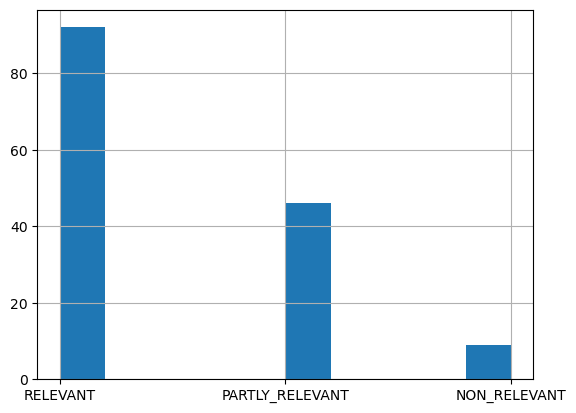

In [48]:
import matplotlib.pyplot as plt
df_results['judgement_relevance'].hist()
plt.savefig("histogram.png")

In [46]:
df_results.to_csv("rag_evaluation_results.csv", index=False)